In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('../data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)
#long_table = pd.read_csv("../code/ReadLengthMapExperimentResults/JuncCountsTidy/LongTable.txt.gz", sep='\t')
long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]#.assay.unique()

Let's see how many junctions and junction reads we have in total.

In [2]:
total_rows = long_table.shape[0]
total_junctions = long_table[['chrom', 'start', 'stop', 'strand']].drop_duplicates().shape[0]
total_junction_reads = long_table.Count.sum()

print('total rows:', total_rows)
print('total junctions:', total_junctions)
print('total junction reads:', total_junction_reads)

total rows: 58456464
total junctions: 2794291
total junction reads: 3649127025


In [3]:
# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])


# long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'end', 'strand', 'gene', 'NewAnnotation'], 
#                  right_on=['chrom', 'start', 'end', 'strand', 'gene', 'NewAnnotation'])



In [4]:
# long_table['ensembl'] = [x.split('.')[0] for x in long_table.gene]
# long_table.loc[long_table.ensembl == 'ENSG00000180573']

One concern is that not all junctions might appear in Yang's annotation. The annotation seems to be done on the trimmed and remapped junctions (maybe it's not...), so many junctions seem to be missing. This might be due to the fact that the longer reads are better at finding new splice junctions. Now let's see how many introns and counts we have left.

In [5]:
filtered_rows = long_table.shape[0]
filtered_junctions = long_table[['chrom', 'start', 'stop', 'strand']].drop_duplicates().shape[0]
filtered_junction_reads = long_table.Count.sum()

print('filtered rows:', filtered_rows)
print('filtered junctions:', filtered_junctions)
print('filtered junction reads:', filtered_junction_reads)

filtered rows: 47701031
filtered junctions: 351668
filtered junction reads: 3616671648


In [6]:
fraction_rows_kept = 100*(filtered_rows/total_rows)
fraction_junctions_kept = 100*(filtered_junctions/total_junctions)
fraction_reads_kept = 100*(filtered_junction_reads/total_junction_reads)

print("fraction rows kept: {:.2f}".format(fraction_rows_kept) + '%')
print("fraction junctions kept: {:.2f}".format(fraction_junctions_kept) + '%')
print("fraction reads kept: {:.2f}".format(fraction_reads_kept) + '%')

fraction rows kept: 81.60%
fraction junctions kept: 12.59%
fraction reads kept: 99.11%


Ok, so less than 1% of reads are actually removed. I won't concern too much about it for now.

Let's define some functions to process the long table and obtain percent of NMD junctions easily. These are not the cleanest, but they will suffice for now.

In [7]:
def longtable_by_annotation(long_table):
    counts_by_annotation = long_table.groupby(['Dataset', 'IndID', 'SuperAnnotation']).Count.sum().reset_index()
    counts_by_semiannotation = long_table.groupby(
        ['Dataset', 'IndID', 'SemiSupergroupAnnotations']
    ).Count.sum().reset_index()
    return counts_by_annotation, counts_by_semiannotation

def get_junction_types(counts_by_annotation, counts_by_semiannotation):
    
    counts = counts_by_annotation.groupby(['Dataset', 'IndID']).Count.sum().reset_index()
    counts.columns = ['Dataset', 'IndID', 'total_counts']

    assay = []
    for i in counts.Dataset:
        if i == 'chRNA.Expression.Splicing':
            assay.append('chRNA')
        elif i == 'Expression.Splicing':
            assay.append('polyA')
        elif i == 'MetabolicLabelled.30min':
            assay.append('4sU 30min')
        elif i == 'MetabolicLabelled.60min':
            assay.append('4sU 60min')

    counts['assay'] = assay

    Protein_coding_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
        ['AnnotatedJunc_UnproductiveCodingGene',
         'UnannotatedJunc_UnproductiveCodingGene',
         'AnnotatedJunc_ProductiveCodingGene',
         'UnannotatedJunc_ProductiveCodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())

    Unproductive_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
        ['AnnotatedJunc_UnproductiveCodingGene',
         'UnannotatedJunc_UnproductiveCodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())

    Productive_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
        ['AnnotatedJunc_ProductiveCodingGene',
         'UnannotatedJunc_ProductiveCodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())

#     Noncoding_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
#         ['AnnotatedJunc_NoncodingGene',
#          'UnannotatedJunc_NoncodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())
    
    
    Annotated_NMD_counts = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
        ['uniquely nonsense_mediated_decay tag'])].groupby(['Dataset', 'IndID']).Count.sum())
    
    unprod_annotations = ['uniquely processed_transcript tag',
       'overlaps processed transcript intron',
       'uniquely retained_intron tag', 'predicted_NMD pstopcodon',
       'predicted_NMD far3p', 'uniquely nonsense_mediated_decay tag',
       'predicted_NMD UTRjunction', 'predicted_NMD YN',
       'predicted_NMD far5p', 'predicted_NMD reason2',
       'overlaps retained_intron tag', 'stable.NY',
       'overlaps nonsense_mediated_decay intron',
       'uniquely non_stop_decay tag', 'predicted_NMD reason1',
       'predicted_NMD NN']

    predicted_annot = [x for x in unprod_annotations if ('predicted_NMD' in x)]

    try:
        Unannotated_NMD_counts = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
            predicted_annot)].groupby(['Dataset', 'IndID']).Count.sum())

        counts['Unannotated_NMD'] = 100*(Unannotated_NMD_counts/Protein_coding_counts)
    except:
        print('No unannotated NMD')

    Annotated_pt_counts = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
        ['uniquely processed_transcript tag'])].groupby(['Dataset', 'IndID']).Count.sum())
    
    counts['Unproductive_juncs'] = 100*(Unproductive_counts/Protein_coding_counts)
    counts['Productive_juncs'] = 100*(Productive_counts/Protein_coding_counts)
#     counts['Noncoding_juncs'] = 100*(Noncoding_counts/counts.total_counts)

    counts['Annotated_NMD'] = 100*(Annotated_NMD_counts/Protein_coding_counts)
    
    counts['Processed_transcripts'] = 100*(Annotated_pt_counts/Protein_coding_counts)
    
    other_unproductive_annot = [x for x in unprod_annotations if (x not in [
        'uniquely processed_transcript tag', 'uniquely nonsense_mediated_decay tag'] + predicted_annot)]
    
    other_unproductive = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
            other_unproductive_annot)].groupby(['Dataset', 'IndID']).Count.sum())
    
    counts['other_unproductive'] = 100*(other_unproductive/Protein_coding_counts)
    
    

    order = ['chRNA', '4sU 30min', '4sU 60min', 'polyA']
    
    return counts, order

def longtable_to_boxplot(long_table):
    
    counts_by_annotation, counts_by_semiannotation = longtable_by_annotation(long_table)
    counts, order = get_junction_types(counts_by_annotation, counts_by_semiannotation)
    
    return counts, order

In [8]:
del intron_annot
counts, order = longtable_to_boxplot(long_table)

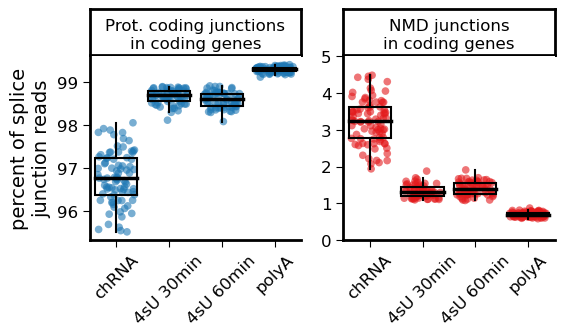

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = counts, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.6, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.6, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
ax[1,1].set_ylim([0, 5])
# ax[1,0].set_ylim([95, 100.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')

ax[1, 1].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)


plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.png', dpi=300, bbox_inches='tight',)

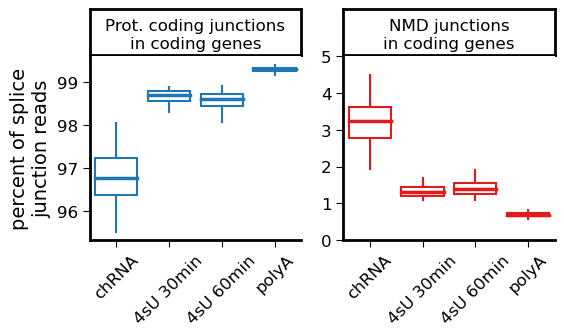

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = counts, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
ax[1,1].set_ylim([0, 5])
# ax[1,0].set_ylim([95, 100.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')

ax[1, 1].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.just_box.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.just_box.png', dpi=300, bbox_inches='tight',)

In [11]:
median_unproductive_chRNA = counts.loc[counts.assay == 'chRNA'].Unproductive_juncs.median()
median_unproductive_ml30 = counts.loc[counts.assay == '4sU 30min'].Unproductive_juncs.median()
median_unproductive_ml60 = counts.loc[counts.assay == '4sU 60min'].Unproductive_juncs.median()
median_unproductive_polyA = counts.loc[counts.assay == 'polyA'].Unproductive_juncs.median()

print("NMD junctions in protein coding genes, in chRNA: {:.2f}".format(median_unproductive_chRNA) + '%')
print("NMD junctions in protein coding genes, in 4sU 30min: {:.2f}".format(median_unproductive_ml30) + '%')
print("NMD junctions in protein coding genes, in 4sU 60min: {:.2f}".format(median_unproductive_ml60) + '%')
print("NMD junctions in protein coding genes, in polyA: {:.2f}".format(median_unproductive_polyA) + '%')

NMD junctions in protein coding genes, in chRNA: 3.24%
NMD junctions in protein coding genes, in 4sU 30min: 1.30%
NMD junctions in protein coding genes, in 4sU 60min: 1.39%
NMD junctions in protein coding genes, in polyA: 0.69%


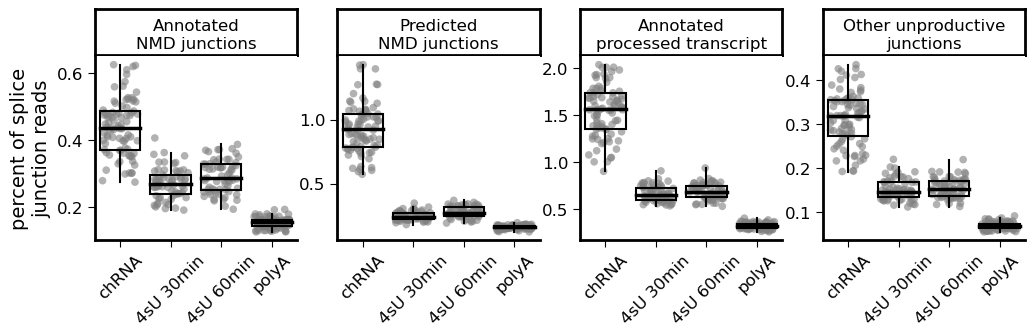

In [12]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = counts, x = 'assay', y = 'Annotated_NMD', jitter=0.35, ax=ax[1, 0], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Annotated_NMD', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unannotated_NMD', jitter=0.35, ax=ax[1, 1], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unannotated_NMD', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Processed_transcripts', jitter=0.35, ax=ax[1, 2], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Processed_transcripts', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'other_unproductive', jitter=0.35, ax=ax[1, 3], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'other_unproductive', width=0.8, ax=ax[1, 3], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(4):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(4):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    


ax[1, 0].set_title('Annotated\nNMD junctions')
ax[1, 1].set_title('Predicted\nNMD junctions')
ax[1, 2].set_title('Annotated\nprocessed transcript')#, y=1.0, pad=12)
ax[1, 3].set_title('Other unproductive\njunctions')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 3].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
ax[1,2].tick_params(length=5, labelsize=12)
ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_breakdown.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_breakdown.png', dpi=300, bbox_inches='tight',)

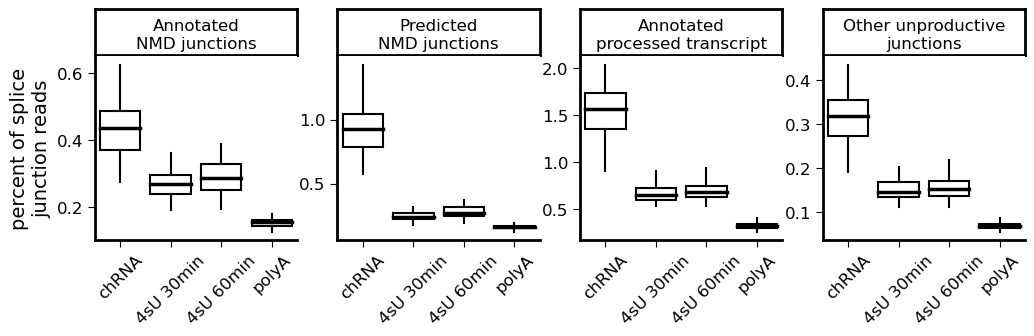

In [13]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.boxplot(data = counts, x = 'assay', y = 'Annotated_NMD', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'Unannotated_NMD', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'Processed_transcripts', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'other_unproductive', width=0.8, ax=ax[1, 3], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(4):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(4):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    


ax[1, 0].set_title('Annotated\nNMD junctions')
ax[1, 1].set_title('Predicted\nNMD junctions')
ax[1, 2].set_title('Annotated\nprocessed transcript')#, y=1.0, pad=12)
ax[1, 3].set_title('Other unproductive\njunctions')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 3].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
ax[1,2].tick_params(length=5, labelsize=12)
ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_breakdown.just_box.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_breakdown.just_box.png', dpi=300, bbox_inches='tight',)

# Leafcutter junctions

Let's see what happens when we use only junctions that are annotated in leafcutter clusters.

In [14]:
# Total_counts = counts_by_annotation.groupby(['Dataset', 'IndID']).score.sum()

In [15]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples
    

chRNA, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')
# ml30, ml30_samples = get_junction_counts(phenotype='MetabolicLabelled.30min')
# ml60, ml60_samples = get_junction_counts(phenotype='MetabolicLabelled.60min')
# polyA, polyA_samples = get_junction_counts(phenotype='Expression.Splicing', subset_samples=YRI_samples)



### Merging long_table to only introns with leafcutter clusters

In [16]:
chRNA['intron_coords'] = chRNA.chrom + ':' + chRNA.start.astype(str) + '-' + chRNA.end.astype(str) + ':' + chRNA.strand
long_table['intron_coords'] = long_table.chrom + ':' + long_table.start.astype(str) + '-' + long_table.end.astype(str) + ':' + long_table.strand

In [17]:
# cluster_table = long_table.merge(chRNA[['chrom', 'start', 'end', 'strand', 'cluster']],
#                  left_on = ['chrom', 'start', 'end', 'strand'],
#                  right_on = ['chrom', 'start', 'end', 'strand'])

In [18]:
cluster_table = long_table.merge(chRNA[['intron_coords', 'cluster']],
                 left_on = 'intron_coords',
                 right_on = 'intron_coords')
cluster_table['intron_length'] = cluster_table.end - cluster_table.start

In [19]:
df_, order = longtable_to_boxplot(cluster_table)

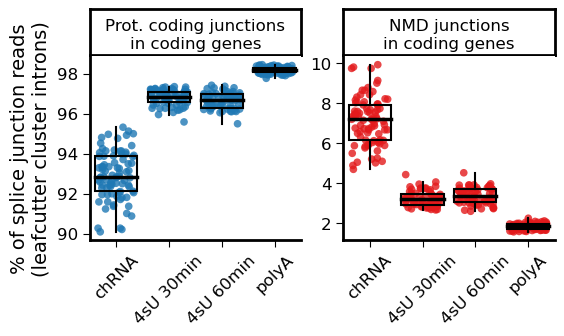

In [20]:
df_, order = longtable_to_boxplot(cluster_table)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = df_, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = df_, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(leafcutter cluster introns)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.png', dpi=300, bbox_inches='tight',)

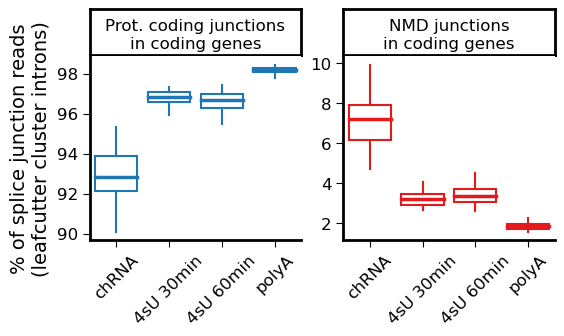

In [21]:
df_, order = longtable_to_boxplot(cluster_table)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(leafcutter cluster introns)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.png', dpi=300, bbox_inches='tight',)

Turns out that the junction reads distribution is very similar than when doing the regular mapping. This suggest that most of the differences between the 3% and the 7% figure likely are due to intron selection, rather than by the remapping itself.

No unannotated NMD


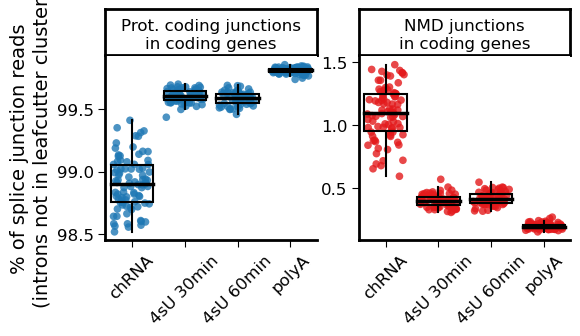

In [22]:
clu_excl = long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]
df_, order = longtable_to_boxplot(clu_excl)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.stripplot(data = df_, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = df_, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(introns not in leafcutter cluster)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.not_in_leafcutter_clusters.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.not_in_leafcutter_clusters.png', dpi=300, bbox_inches='tight',)

No unannotated NMD


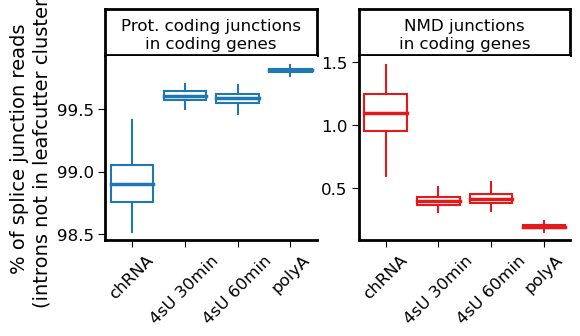

In [23]:
clu_excl = long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]
df_, order = longtable_to_boxplot(clu_excl)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(introns not in leafcutter cluster)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.not_in_leafcutter_clusters.just_box.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.not_in_leafcutter_clusters.just_box.png', dpi=300, bbox_inches='tight',)

Non-leafcutter introns are more likely to be annotated in protein coding genes. These are probably just constitutive junctions in protein coding genes. As a result, the % of NMD junction reads is much lower in the group of junctions not in leafcutter clusters.

Thus overall I think that the 3% figure is closer to the truth.

In [24]:
percent_pc_not_in_cluster = (clu_excl.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene').mean()*100
percent_pc_in_leafcutter_cluster = (cluster_table.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene').mean()*100

In [25]:
# long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]

(cluster_table.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene').mean()

0.6917094781841822

In [26]:
(clu_excl.SuperAnnotation == 'UnannotatedJunc_ProductiveCodingGene').mean()

1.7023336278063344e-05

In [27]:
(clu_excl.SuperAnnotation == 'UnannotatedJunc_UnproductiveCodingGene').mean()

4.064260911970679e-05

In [28]:
(clu_excl.SuperAnnotation == 'AnnotatedJunc_UnproductiveCodingGene').mean()

0.04015446131446831

In [29]:
(clu_excl.SuperAnnotation == 'AnnotatedJunc_NoncodingGene').mean()

0.019641680596136867

In [30]:
(clu_excl.SuperAnnotation == 'UnannotatedJunc_NoncodingGene').mean()

8.244920704475124e-07

In [31]:
long_table.shape

(47701031, 16)

In [32]:
cluster_max_length = cluster_table.loc[cluster_table.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
)].groupby('cluster').intron_length.max()

def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

clu_1, clu_2, clu_3, clu_4 = get_series_quantile(cluster_max_length)

lt1 = cluster_table.loc[cluster_table.cluster.isin(clu_1)]
df1, order = longtable_to_boxplot(lt1)

lt2 = cluster_table.loc[cluster_table.cluster.isin(clu_2)]
df2, order = longtable_to_boxplot(lt2)

lt3 = cluster_table.loc[cluster_table.cluster.isin(clu_3)]
df3, order = longtable_to_boxplot(lt3)

lt4 = cluster_table.loc[cluster_table.cluster.isin(clu_4)]
df4, order = longtable_to_boxplot(lt4)

In [33]:
clu_df = pd.DataFrame()
unprod_juncs = list(df1.loc[df1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df2.loc[df2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df3.loc[df3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df4.loc[df4.assay=='chRNA'].Unproductive_juncs)

clu_df['unprod_juncs'] = unprod_juncs
clu_df['length_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

In [34]:
RPKM_median = RPKM[pd.Index(cluster_table.IndID.unique()).intersection(RPKM.columns)].median(axis=1)
rpkm_1, rpkm_2, rpkm_3, rpkm_4 = get_series_quantile(RPKM_median)


In [35]:
lt1 = long_table.loc[long_table.gene.isin(rpkm_1)]
df_rpkm1, order = longtable_to_boxplot(lt1)

lt2 = long_table.loc[long_table.gene.isin(rpkm_2)]
df_rpkm2, order = longtable_to_boxplot(lt2)

lt3 = long_table.loc[long_table.gene.isin(rpkm_3)]
df_rpkm3, order = longtable_to_boxplot(lt3)

lt4 = long_table.loc[long_table.gene.isin(rpkm_4)]
df_rpkm4, order = longtable_to_boxplot(lt4)

In [36]:
rpkm_df = pd.DataFrame()
unprod_juncs = list(df_rpkm1.loc[df_rpkm1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm2.loc[df_rpkm2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm3.loc[df_rpkm3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm4.loc[df_rpkm4.assay=='chRNA'].Unproductive_juncs)

rpkm_df['unprod_juncs'] = unprod_juncs
rpkm_df['rpkm_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

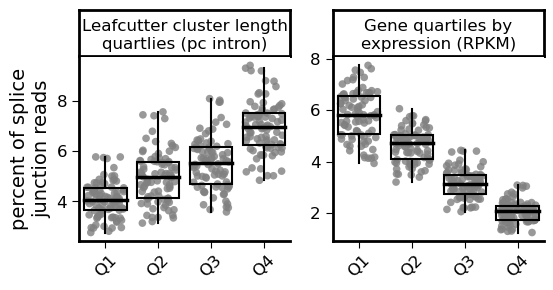

In [37]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data=clu_df, x='length_quartile', y='unprod_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data=clu_df, x='length_quartile', y='unprod_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Leafcutter cluster length\nquartlies (pc intron)')
ax[1, 1].set_title('Gene quartiles by\nexpression (RPKM)')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.png', dpi=300, bbox_inches='tight',)

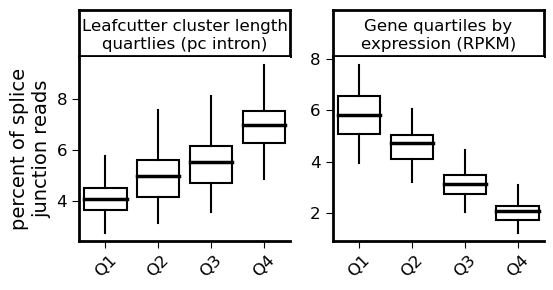

In [38]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


# sns.stripplot(data=clu_df, x='length_quartile', y='unprod_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
#               color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data=clu_df, x='length_quartile', y='unprod_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
#               color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Leafcutter cluster length\nquartlies (pc intron)')
ax[1, 1].set_title('Gene quartiles by\nexpression (RPKM)')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.just_box.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.just_box.png', dpi=300, bbox_inches='tight',)

In [39]:
import sys

sys.path.append('../code/scripts/useful_modules')

# Some useful functions for plotting that I wrote previously
from plot_functions import *
from regression_functions import *

In [40]:
NMD_annot = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
pc_annot = ['UnannotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']

NMD_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(NMD_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

pc_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(pc_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

genes_index = NMD_counts.index.intersection(pc_counts.index)

chRNA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

ml30_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/MetabolicLabelled.30min/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]


In [41]:
polyA_log2RPKM = polyA_RPKM[polyA_RPKM.columns[5:]].median(axis=1)
ml30_log2RPKM = ml30_RPKM[ml30_RPKM.columns[5:]].median(axis=1)
chRNA_log2RPKM = chRNA_RPKM[chRNA_RPKM.columns[5:]].median(axis=1)


polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
ml30_log2RPKM.index = [x.split('.')[0] for x in ml30_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
NMD_counts.index = [x.split('.')[0] for x in NMD_counts.index]
pc_counts.index = [x.split('.')[0] for x in pc_counts.index]


chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(polyA_genes).intersection(NMD_counts.index).intersection(pc_counts.index)


total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts

chRNA_juncs_NMD_ratio = np.log2(NMD_percent.loc[genes_index].mean(axis=1))




NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
chRNA_polyA_log2_difference = chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]
ml30_polyA_log2_difference = ml30_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]

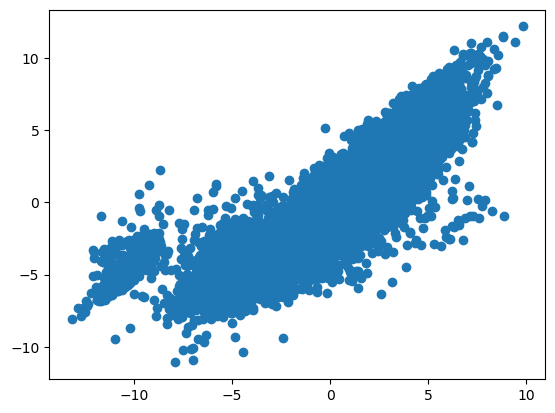

In [42]:
plt.scatter(chRNA_log2RPKM, polyA_log2RPKM)

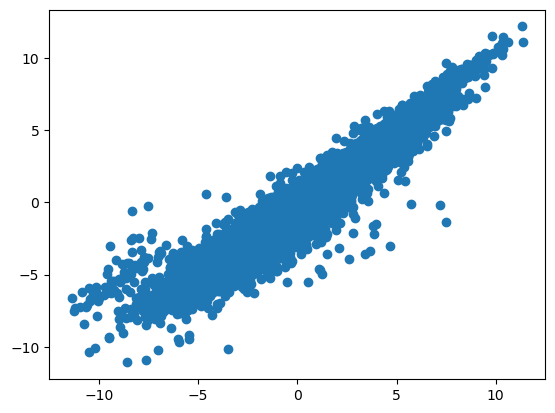

In [43]:
plt.scatter(ml30_log2RPKM, polyA_log2RPKM)

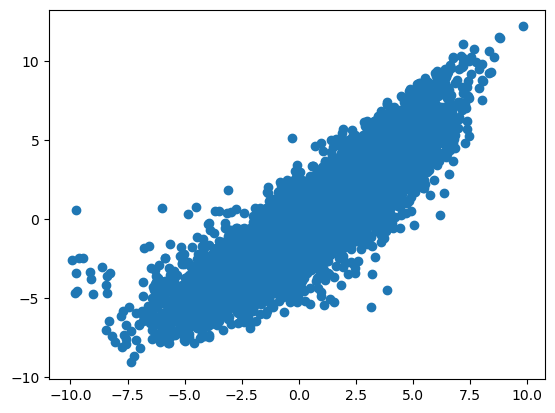

In [44]:
chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(genes_index).intersection(polyA_genes)

plt.scatter(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index])

In [45]:
total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts


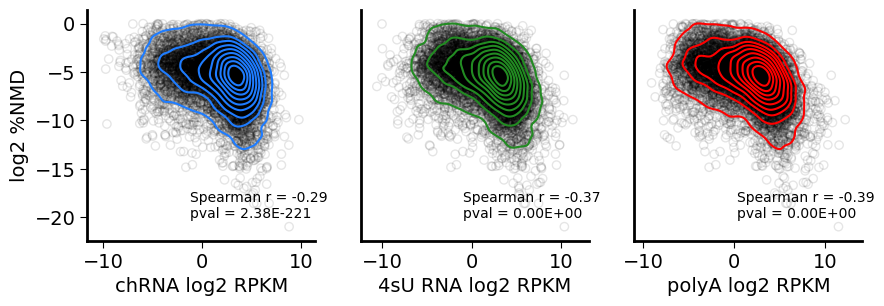

In [46]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'hspace': 0.2}, figsize=(10, 3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax[0], xy=(0.45, 0.1), **kwargs)

plot_correlation(ml30_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='forestgreen', #title='chRNA',
                 xlabel='4sU RNA log2 RPKM', ax=ax[1], xy=(0.45, 0.1), **kwargs)

plot_correlation(polyA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='red', #title='chRNA',
                 xlabel='polyA log2 RPKM', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log2 %NMD', size=14)

ax[1].set_yticks([])
ax[2].set_yticks([])

plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_RPKM_v_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_RPKM_v_NMD.png', dpi=300, bbox_inches='tight',)

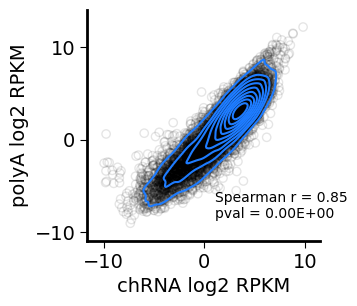

In [47]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('chRNA log2 RPKM', size=14)
ax.set_ylabel('polyA log2 RPKM', size=14)

plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.pdf', bbox_inches='tight', dpi=300)

In [48]:
def plot_cumulative_quantiles(X, quantile_list, color_list, label_list = None,
                               method='median', ax=None, plot_legend = False, norm_to_Q1 = False, 
                               **kwargs):
    for i in range(len(quantile_list)):
        Qi = quantile_list[i]
        color = color_list[i]
        
        if label_list is None:
            label = 'Q' + str(i+1)
        else:
            label = label_list[i]
            
#         if method == '':
#             for j in X.columns:
#                 X_to_plot = X.loc[Qi, j]
#                 plot_cumulative(X_to_plot, c=color, ax=ax, alpha=0.4)
#             continue
        
#         elif method == 'median':
#             X_to_plot = np.array(X.loc[Qi].median(axis=1))
            
            
#         elif method == 'mean':
        X_to_plot = np.array(X.loc[Qi])
            
        if norm_to_Q1:
            if i == 0:
                Q1_ = X_to_plot
                continue
            else:
                X_to_plot = X_to_plot/Q1_

        plot_cumulative(X_to_plot, c=color, ax=ax, label=label)
            
        
                
    if ax:
        if plot_legend:
            if 'legend_title' in kwargs:
                ax.legend(title = kwargs['legend_title'], frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(frameon=False,
                         loc='center left', bbox_to_anchor=(1, 0.5))
        if 'xlim' in kwargs:
            ax.set_xlim(kwargs['xlim'])
        if 'ylim' in kwargs:
            ax.set_ylim(kwargs['ylim'])
        if 'xticks' in kwargs:
            ax.set_xticks(kwargs['xticks'])
        if 'xticklabels' in kwargs:
            ax.set_xticklabels(kwargs['xticklabels'])
        if 'yticks' in kwargs:
            ax.set_yticks(kwargs['yticks'])
        if 'yticklabels' in kwargs:
            ax.set_yticklabels(kwargs['yticklabels'])
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.tick_params(size=4, width=2, labelsize=kwargs['fontsize'])
        if 'vertical_line_at' in kwargs:
            ax.plot([kwargs['vertical_line_at'], kwargs['vertical_line_at']], 
                    [0, 1], linestyle='--', c='gray')
        if 'xlabel' in kwargs:
            ax.set_xlabel(kwargs['xlabel'], fontsize=kwargs['fontsize'])
        if 'ylabel' in kwargs:
            ax.set_ylabel(kwargs['ylabel'], fontsize=kwargs['fontsize'])
        if 'title' in kwargs:
            ax.set_title(kwargs['title'], fontsize=kwargs['fontsize'])


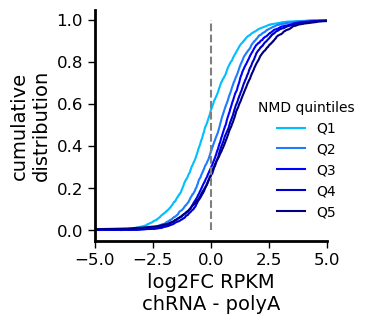

In [49]:

figsize = (3, 3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax,
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=16, label_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], method='')

ax.legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(0.65, 0.35), 
          fontsize=10, title_fontsize = 10)
ax.tick_params(length=5, labelsize=12, width=1)


ax.set_ylabel('cumulative\ndistribution',size=14)
ax.set_xlabel('log2FC RPKM\nchRNA - polyA',size=14)

plt.show()
# xlabel='log2FC RPKM\nchRNA - polyA',
# plt.savefig(figdir + 'Fig1.coverage_distribution.chRNA.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'Fig1.coverage_distribution.chRNA.png', dpi=300, bbox_inches='tight',)

In [50]:
# We get H3K36ME3 coverage over the gene body
h3k36me3_logRPKM = pd.read_csv(
    '../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

h3k36me3_logRPKM = h3k36me3_logRPKM[h3k36me3_logRPKM.columns[5:]]
h3k36me3_logRPKM.index = [x.split('.')[0] for x in h3k36me3_logRPKM.index]

# Get log2 fold difference
h3k36me3_log2RPKM = h3k36me3_logRPKM.loc[genes_index]
h3k36me3_polyA_log2_difference = h3k36me3_log2RPKM.median(axis=1) - polyA_log2RPKM


# For H3K4ME3, it's a bit trickier. We get the CPM of the peaks that are close (within 2000 bp) of
# a TSS for each gene

H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = H3K4ME3.columns[5:]
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_CPM.index = [x.split('.')[0] for x in h3k4me3_CPM.index]

h3k4me3_idx = genes_index.intersection(h3k4me3_CPM.index)
h3k4me3_log2RPKM = np.log2(h3k4me3_CPM.loc[h3k4me3_idx]) 
h3k4me3_log2RPKM = h3k4me3_log2RPKM.loc[h3k4me3_log2RPKM.median(axis=1) > -1e100]
h3k4me3_idx = h3k4me3_log2RPKM.index
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k4me3_idx]




H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns[5:]
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_CPM.index = [x.split('.')[0] for x in h3k27ac_CPM.index]

h3k27ac_idx = genes_index.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k27ac_idx]



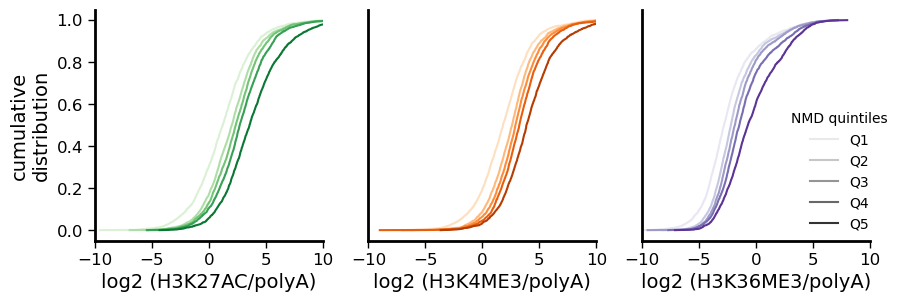

In [51]:
# chRNA vs polyA, K4ME3 vs polyA, and K36ME3 vs polyA; 4sU vs polyA

h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)

h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

# figsize = (5.25, 5.25)
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'hspace': 0.2}, figsize=(10, 3))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)

plot_cumulative_quantiles(h3k27ac_polyA_log2_difference.loc[h3k27ac_idx], NMD_ratio_quant_all_h3k27ac, 
                    sns.color_palette("Greens", 5), xlim=[-10,10], ax=ax[0],
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2 (H3K27AC/polyA)', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Oranges", 5), xlim=[-10,10], ax=ax[1],
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2 (H3K4ME3/polyA)', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                    sns.color_palette("Purples", 5), xlim=[-10,10], ax=ax[2],
#                           vertical_line_at = 0,
#                           ylabel='H3K36ME3 - polyA\ncumulative distribution',
                   xlabel = 'log2 (H3K36ME3/polyA)', legend_title = '%NMD quintiles', fontsize=14,
                         label_list = [None, None, None, None, None])

# ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

# ax[0,1].set_xlabel("")
# ax[0,0].set_xlabel("")

# ax[0,1].plot([-50], [0.5], c = 'blue', label = 'chRNA')
# ax[0,1].plot([-50], [0.5], c = sns.color_palette("Greens", 5)[4], label = '4sU RNA')
# ax[2].plot([-50], [0.5], c = sns.color_palette("Oranges", 5)[4], label = 'H3K4ME3')
# ax[2].plot([-50], [0.5], c = sns.color_palette("Purples", 5)[4], label = 'H3K36ME3')

# ax[2].legend(title = 'logFC vs polyA', frameon=False, 
#                           loc='center left', bbox_to_anchor=(1, 0.5))

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[2].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[2].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(0.6, 0.3))

ax[0].tick_params(length=5, labelsize=12, width=1)
ax[1].tick_params(length=5, labelsize=12, width=1)
ax[2].tick_params(length=5, labelsize=12, width=1)
# ax[1,1].tick_params(length=5, labelsize=12, width=1)

ax[0].set_ylabel('cumulative\ndistribution',size=14)



# plt.show()

# plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)
# plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.pdf', bbox_inches='tight', dpi=300)

plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_Histones_LFC.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_Histones_LFC.png', dpi=300, bbox_inches='tight',)

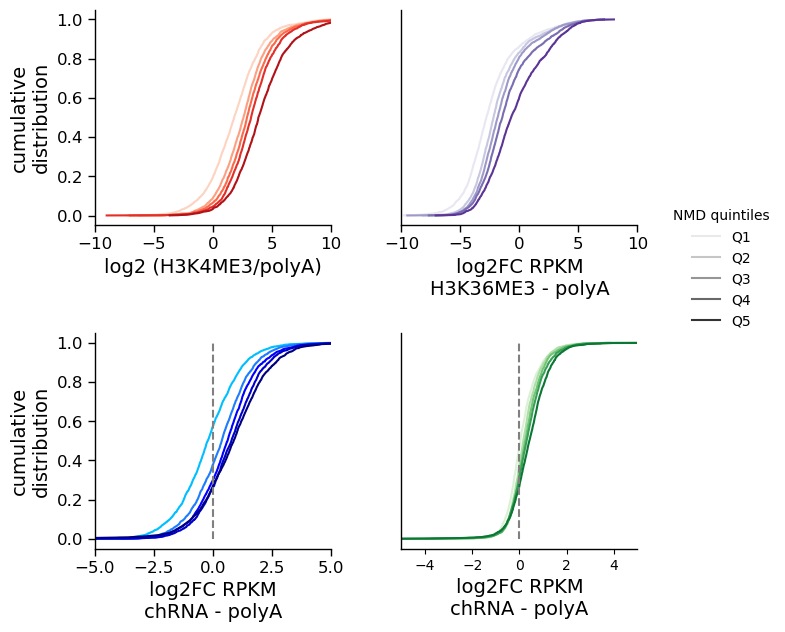

In [52]:
# chRNA vs polyA, K4ME3 vs polyA, and K36ME3 vs polyA; 4sU vs polyA

h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)

h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

# figsize = (5.25, 5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, figsize=(7, 7))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Reds", 5), xlim=[-10,10], ax=ax[0, 0],
                          xlabel = 'log2 (H3K4ME3/polyA)',
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                    sns.color_palette("Purples", 5), xlim=[-10,10], ax=ax[0,1],
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[1,0], label_list = [None, None, None, None, None],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=14, method='')

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   sns.color_palette("Greens", 5), 
                                   ax=ax[1,1], label_list = [None, None, None, None, None],
#                                    ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=14, method='')

# plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
#                     sns.color_palette("Purples", 5), xlim=[-10,10], ax=ax[2],
# #                           vertical_line_at = 0,
# #                           ylabel='H3K36ME3 - polyA\ncumulative distribution',
#                    xlabel = 'log2 (H3K36ME3/polyA)', legend_title = '%NMD quintiles', fontsize=14,
#                          label_list = [None, None, None, None, None])

# ax[0].set_yticks([])
ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

# ax[0,1].set_xlabel("")
# ax[0,0].set_xlabel("")

# ax[0,1].plot([-50], [0.5], c = 'blue', label = 'chRNA')
# ax[0,1].plot([-50], [0.5], c = sns.color_palette("Greens", 5)[4], label = '4sU RNA')
# ax[2].plot([-50], [0.5], c = sns.color_palette("Oranges", 5)[4], label = 'H3K4ME3')
# ax[2].plot([-50], [0.5], c = sns.color_palette("Purples", 5)[4], label = 'H3K36ME3')

# ax[2].legend(title = 'logFC vs polyA', frameon=False, 
#                           loc='center left', bbox_to_anchor=(1, 0.5))

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[1,1].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[1,1].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1.1, 1.3))

ax[0,0].tick_params(length=5, labelsize=12, width=1)
ax[0,1].tick_params(length=5, labelsize=12, width=1)
ax[1,0].tick_params(length=5, labelsize=12, width=1)
# ax[1,1].tick_params(length=5, labelsize=12, width=1)

ax[0,0].set_ylabel('cumulative\ndistribution',size=14)

for ax_ in [ax[0,0], ax[1,0], ax[0,1], ax[1,1]]:
    ax_.spines['left'].set_linewidth(1)
    ax_.spines['bottom'].set_linewidth(1)

# plt.show()

# plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)
# plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.pdf', bbox_inches='tight', dpi=300)

# plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_Histones_LFC.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_Histones_LFC.png', dpi=300, bbox_inches='tight',)

plt.savefig(figdir + 'Fig1.coverage_distribution.chRNA.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Fig1.coverage_distribution.chRNA.png', dpi=300, bbox_inches='tight',)

In [53]:
# ax[0,0].spines

In [54]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)
polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
chRNA_juncs_NMD_ratio.index = [x.split('.')[0] for x in chRNA_juncs_NMD_ratio.index]

ensembl_idx = chRNA_juncs_NMD_ratio.index.intersection(scores.index).intersection(chRNA_log2RPKM.index)
df_scores = scores.loc[ensembl_idx]
df_scores['NMD'] = np.array(chRNA_juncs_NMD_ratio.loc[ensembl_idx])
df_scores['RPKM'] = np.array(chRNA_log2RPKM.loc[ensembl_idx])
df_scores['logFC'] = np.array(chRNA_log2RPKM.loc[ensembl_idx] - polyA_log2RPKM.loc[ensembl_idx])

In [55]:
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

In [56]:
srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(ensembl_idx)
df_scores_sr = df_scores.loc[srsf_ensembl]
df_scores_sr['gene'] = np.array(genes.loc[srsf_ensembl].genes)

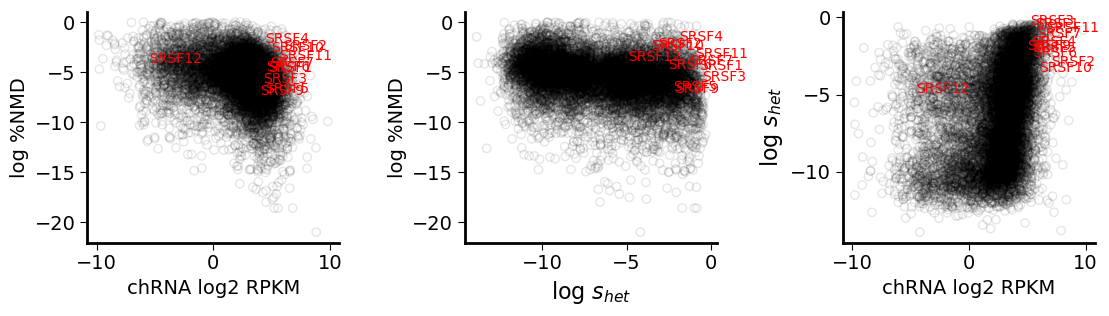

In [57]:
df_scores_sr
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.5}, figsize=(13, 3))

ax[0].scatter(df_scores.RPKM, df_scores.NMD, **kwargs)
for idx, row in df_scores_sr.iterrows():
    ax[0].annotate(row.gene, (row.RPKM-1, row.NMD-0.2), c='red', size=10)
    
ax[1].scatter(np.log2(df_scores.post_mean),df_scores.NMD, **kwargs)
for idx, row in df_scores_sr.iterrows():
    ax[1].annotate(row.gene, (np.log2(row.post_mean), row.NMD), c='red', size=10)
    
    
ax[2].scatter(df_scores.RPKM, np.log2(df_scores.post_mean), **kwargs)
for idx, row in df_scores_sr.iterrows():
    ax[2].annotate(row.gene, (row.RPKM, np.log2(row.post_mean)), c='red', size=10)


for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log %NMD', size=14)

ax[1].set_ylabel('log %NMD', size=14)
ax[1].set_xlabel('log $s_{het}$', size=16)


ax[2].set_xlabel('chRNA log2 RPKM', size=14)
ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])


plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [58]:
gene_len = RPKM.end - RPKM.start
gene_len.index = [x.split('.')[0] for x in gene_len.index]
# df_scores['intron_length'] = np.array(np.log(intron_len.loc[df_scores.index]))
df_scores['gene_length'] = np.array(np.log2(gene_len.loc[df_scores.index]))
# df_scores['intron_counts'] = np.array(np.log(intron_counts.loc[df_scores.index]))

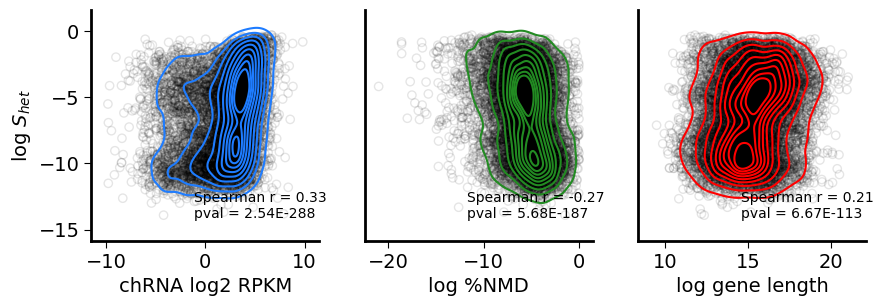

In [59]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'hspace': 0.2}, figsize=(10, 3))

plot_correlation(df_scores.RPKM, np.log2(df_scores.post_mean),
                 contour_color='#1e7cff', ylabel='log $S_{het}$', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax[0], xy=(0.45, 0.1), **kwargs)

plot_correlation(df_scores.NMD, np.log2(df_scores.post_mean),
                 contour_color='forestgreen', #title='chRNA',
                 xlabel='log %NMD', ax=ax[1], xy=(0.45, 0.1), **kwargs)

plot_correlation(df_scores.gene_length, np.log2(df_scores.post_mean),
                 contour_color='red', #title='chRNA',
                 xlabel='log gene length', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
# ax[0].set_xlabel('chRNA log2 RPKM', size=14)
# ax[0].set_ylabel('logit pLI score', size=14)

# ax[0].set_xlabel('chRNA log2 RPKM', size=14)


ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].set_ylabel('')
ax[2].set_ylabel('')



plt.savefig(figdir + 'supplementary_figures/features_vs_s_het.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/features_vs_s_het.png', dpi=300, bbox_inches='tight',)

# plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_RPKM_v_NMD.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_RPKM_v_NMD.png', dpi=300, bbox_inches='tight',)

In [60]:
def get_gene_quartiles(array, genes):
    
    feature1, feature2, feature3, feature4 = get_series_quantile(array.loc[genes], quant=4)

    feature_rank = []
    for gen in genes:
        if gen in feature1:
            feature_rank.append('Q1')
        elif gen in feature2:
            feature_rank.append('Q2')
        elif gen in feature3:
            feature_rank.append('Q3')
        elif gen in feature4:
            feature_rank.append('Q4')
    return feature_rank

rpkm1, rpkm2, rpkm3, rpkm4 = get_series_quantile(chRNA_log2RPKM.loc[ensembl_idx], quant=4)
NMD1, NMD2, NMD3, NMD4 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[ensembl_idx], quant=4)



rpkm_rank = []
for ens in ensembl_idx:
    if ens in rpkm1:
        rpkm_rank.append('Q1')
    elif ens in rpkm2:
        rpkm_rank.append('Q2')
    elif ens in rpkm3:
        rpkm_rank.append('Q3')
    elif ens in rpkm4:
        rpkm_rank.append('Q4')
    

NMD_rank = []
for gen in ensembl_idx:
    if gen in NMD1:
        NMD_rank.append('Q1')
    elif gen in NMD2:
        NMD_rank.append('Q2')
    elif gen in NMD3:
        NMD_rank.append('Q3')
    elif gen in NMD4:
        NMD_rank.append('Q4')
    
df_scores['rpkm_quartiles'] = rpkm_rank
df_scores['NMD_quartiles'] = NMD_rank


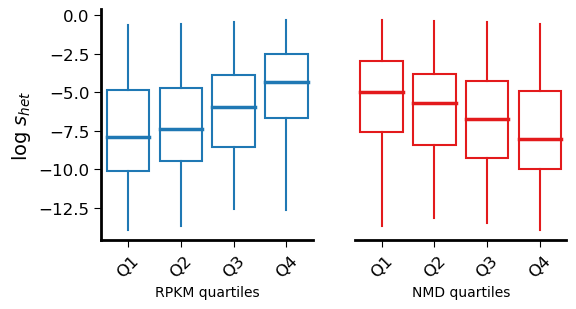

In [61]:
df_scores['log_s_het'] = np.log2(df_scores.post_mean)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df_scores, x = 'rpkm_quartiles', y = 'log_s_het', width=0.8, ax=ax[0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

sns.boxplot(data = df_scores, x = 'NMD_quartiles', y = 'log_s_het', width=0.8, ax=ax[1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])


for x in range(2):
    ax[x].spines['left'].set_linewidth(2)
    ax[x].spines['bottom'].set_linewidth(2)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    ax[x].tick_params(axis='x', rotation=45)
    ax[x].set_xlabel('')
    
ax[1].spines['left'].set_visible(False)


ax[0].set_xlabel('RPKM quartiles')
ax[1].set_xlabel('NMD quartiles')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[0].set_ylabel('log $s_{het}$', size=14)

ax[1].set_yticks([])

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)



plt.savefig(figdir + 'supplementary_figures/quartiles.s_het.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/quartiles.s_het.png', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.pdf_scores', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.png', dpi=300, bbox_inches='tight',)

In [62]:
pLI = pd.read_csv('../../gnomad.v2.1.1.lof_metrics.by_gene.txt', sep='\t')
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]
pLI_by_gene = pLI.groupby('gene')[['exac_pLI', 'exac_obs_lof', 'exac_exp_lof', 'exac_oe_lof']].max().dropna()#.reset_index()

genes_score = df_scores.index

pLI_genes = pd.Index(pLI_by_gene.loc[pLI_by_gene.index.intersection(pd.Index(genes.loc[genes_score].genes))].index)
ensembl_ = genes.loc[genes.genes.isin(pLI_genes)].index.intersection(genes_score)
genes_ = pd.Index(genes.loc[ensembl_].genes)


df = pd.DataFrame()
df['ensembl'] = ensembl_
df['genes'] = genes_

# df['pLI'] = np.array(pLI_by_gene.loc[genes_].exac_pLI)

df['pLI'] = np.array(pLI_by_gene.loc[genes_].exac_pLI)
df['logit_pLI'] = np.array(np.log2(pLI_by_gene.loc[genes_].exac_pLI/((1-pLI_by_gene.loc[genes_].exac_pLI)+1e-7)))

df['lof'] = np.array(np.log2(pLI_by_gene.loc[genes_].exac_obs_lof))
df['NMD'] = np.array(chRNA_juncs_NMD_ratio.loc[ensembl_])
df['rpkm'] = np.array(chRNA_log2RPKM.loc[ensembl_])

def get_gene_quartiles(array, genes):
    
    feature1, feature2, feature3, feature4 = get_series_quantile(array.loc[genes], quant=4)

    feature_rank = []
    for gen in genes:
        if gen in feature1:
            feature_rank.append('Q1')
        elif gen in feature2:
            feature_rank.append('Q2')
        elif gen in feature3:
            feature_rank.append('Q3')
        elif gen in feature4:
            feature_rank.append('Q4')
    return feature_rank

rpkm1, rpkm2, rpkm3, rpkm4 = get_series_quantile(chRNA_log2RPKM.loc[ensembl_], quant=4)
pLI1, pLI2, pLI3, pLI4 = get_series_quantile(pLI_by_gene.loc[genes_].exac_pLI, quant=4)
NMD1, NMD2, NMD3, NMD4 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[ensembl_], quant=4)


# rpkm_rank = get_gene_quartiles(chRNA_log2RPKM, ensembl_)
# pLI_rank = get_gene_quartiles(pLI_by_gene, genes_)
# NMD_rank = get_gene_quartiles(chRNA_juncs_NMD_ratio, ensembl_)


rpkm_rank = []
for ens in ensembl_:
    if ens in rpkm1:
        rpkm_rank.append('Q1')
    elif ens in rpkm2:
        rpkm_rank.append('Q2')
    elif ens in rpkm3:
        rpkm_rank.append('Q3')
    elif ens in rpkm4:
        rpkm_rank.append('Q4')
    
pLI_rank = []
for gen in genes_:
    if gen in pLI1:
        pLI_rank.append('Q1')
    elif gen in pLI2:
        pLI_rank.append('Q2')
    elif gen in pLI3:
        pLI_rank.append('Q3')
    elif gen in pLI4:
        pLI_rank.append('Q4')
        
NMD_rank = []
for gen in ensembl_:
    if gen in NMD1:
        NMD_rank.append('Q1')
    elif gen in NMD2:
        NMD_rank.append('Q2')
    elif gen in NMD3:
        NMD_rank.append('Q3')
    elif gen in NMD4:
        NMD_rank.append('Q4')
    
df['rpkm_quartiles'] = rpkm_rank
df['pLI_quartiles'] = pLI_rank
df['NMD_quartiles'] = NMD_rank

df = df.set_index('ensembl')
# df['lof_quartiles'] = get_gene_quartiles(df.lof, df.index)


/project2/mstephens/cfbuenabadn/anaconda3/envs/jnotebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


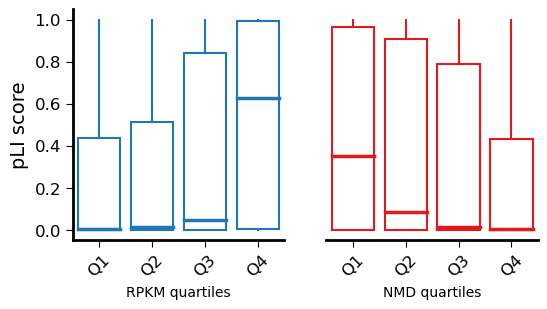

In [63]:

# sns.boxplot(data = df, x='rpkm_quartiles', y='pLI', order=['Q1', 'Q2', 'Q3', 'Q4'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df, x = 'rpkm_quartiles', y = 'pLI', width=0.8, ax=ax[0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

sns.boxplot(data = df, x = 'NMD_quartiles', y = 'pLI', width=0.8, ax=ax[1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[x].spines['left'].set_linewidth(2)
    ax[x].spines['bottom'].set_linewidth(2)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    ax[x].tick_params(axis='x', rotation=45)
    ax[x].set_xlabel('')
    
ax[1].spines['left'].set_visible(False)
# for x in range(2):
#     ax[0,x].spines['left'].set_linewidth(2)
#     ax[0,x].spines['bottom'].set_linewidth(2)
#     ax[0,x].spines['right'].set_linewidth(2)
#     ax[0,x].spines['top'].set_linewidth(2)
#     ax[0, x].set_xticks([])
#     ax[0, x].set_yticks([])
#     ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[0].set_xlabel('RPKM quartiles')
ax[1].set_xlabel('NMD quartiles')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[0].set_ylabel('pLI score', size=14)

ax[1].set_yticks([])

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)



plt.savefig(figdir + 'supplementary_figures/quartiles_v_pLI.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/quartiles_v_pLI.png', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.png', dpi=300, bbox_inches='tight',)

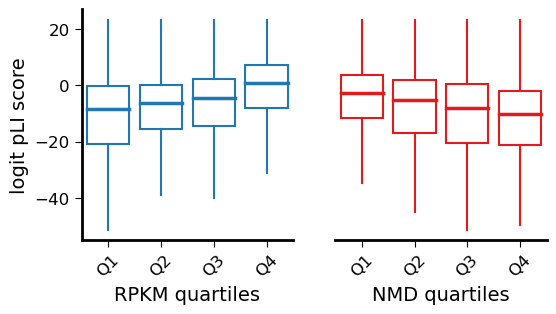

In [64]:

# sns.boxplot(data = df, x='rpkm_quartiles', y='pLI', order=['Q1', 'Q2', 'Q3', 'Q4'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df, x = 'rpkm_quartiles', y = 'logit_pLI', width=0.8, ax=ax[0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

sns.boxplot(data = df, x = 'NMD_quartiles', y = 'logit_pLI', width=0.8, ax=ax[1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[x].spines['left'].set_linewidth(2)
    ax[x].spines['bottom'].set_linewidth(2)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    ax[x].tick_params(axis='x', rotation=45)
    ax[x].set_xlabel('')
    
ax[1].spines['left'].set_visible(False)
# for x in range(2):
#     ax[0,x].spines['left'].set_linewidth(2)
#     ax[0,x].spines['bottom'].set_linewidth(2)
#     ax[0,x].spines['right'].set_linewidth(2)
#     ax[0,x].spines['top'].set_linewidth(2)
#     ax[0, x].set_xticks([])
#     ax[0, x].set_yticks([])
#     ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[0].set_xlabel('RPKM quartiles', size=14)
ax[1].set_xlabel('NMD quartiles', size=14)
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[0].set_ylabel('logit pLI score', size=14)

ax[1].set_yticks([])

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)



plt.savefig(figdir + 'supplementary_figures/quartiles_v_logitpLI.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/quartiles_v_logitpLI.png', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.png', dpi=300, bbox_inches='tight',)

In [65]:
df_srsf = df.loc[df.genes.isin(['SRSF'+str(x) for x in range(13)])]

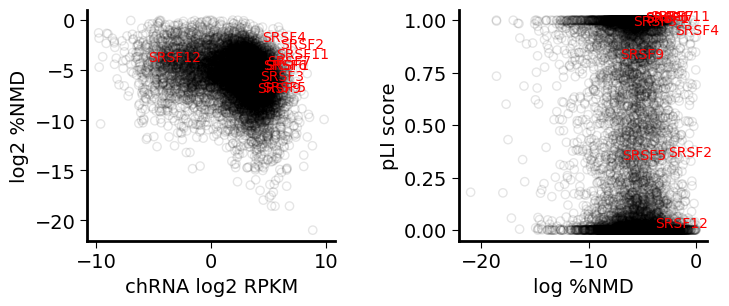

In [66]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(df.rpkm, df.NMD, **kwargs)
for idx, row in df_srsf.iterrows():
    ax[0].annotate(row.genes, (row.rpkm-1, row.NMD-0.2), c='red', size=10)
    
ax[1].scatter(df.NMD, df.pLI, **kwargs)
for idx, row in df_srsf.iterrows():
    ax[1].annotate(row.genes, (row.NMD, row.pLI), c='red', size=10)


# plot_correlation(df.exon_counts, df.logit_pLI,
#                  contour_color='#1e7cff', ylabel='logit pLI score', #title='chRNA',
#                  xlabel='log exon number', ax=ax[0], xy=(0.45, 0.1), **kwargs)

# plot_correlation(df.gene_length, df.logit_pLI,
#                  contour_color='forestgreen', #title='chRNA',
#                  xlabel='log gene length', ax=ax[1], xy=(0.45, 0.1), **kwargs)

# plot_correlation(df.intron_counts, df.logit_pLI,
#                  contour_color='red', #title='chRNA',
#                  xlabel='polyA log2 RPKM', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log2 %NMD', size=14)

ax[1].set_xlabel('log %NMD', size=14)
ax[1].set_ylabel('pLI score', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

In [67]:
df_scores
model, r2 = run_regression(df_scores, ['RPKM', 'log_s_het'], 'NMD')

In [68]:
model.params

const       -6.179264
RPKM        -0.178375
log_s_het   -0.154625
dtype: float64

In [69]:
from scipy.stats import zscore

In [70]:
def run_regression(df, X_list, Y_, robust = False, method=None, alpha=None):
    
    X = df[X_list]
    Y = df[Y_]
    X = sm.add_constant(X) # add a constant term to the regression
    if robust:
        model = sm.RLM(Y, X).fit()
    else:
        if method and alpha:
            model = sm.OLS(Y, X).fit_regularized(alpha=alpha, method=method)
        else:
            model = sm.OLS(Y, X).fit()

    
    
#     coef = model.params#[X_list]

    y_true = Y
    y_pred = model.predict(X)
    u = ((y_true - y_pred)**2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1-(u/v)
    
#     try:
#         coef = float(coef)
#     except:
#         pass
#     intercept = float(model.params.loc['const'])
    
    
    return model, r2, y_pred#var_explained

In [71]:
dfreg = pd.DataFrame()
dfreg['RPKM'] = df_scores.RPKM
dfreg['gene_length'] = np.array(df_scores.gene_length)
dfreg['log_s_het'] = np.array(df_scores.log_s_het)
dfreg['NMD'] = np.array(df_scores.NMD)

dfreg = dfreg.loc[dfreg.RPKM > np.log2(5)]

dfreg['zRPKM'] = zscore(df_scores.loc[dfreg.index].RPKM)
dfreg['zgene_length'] = zscore(df_scores.loc[dfreg.index].gene_length)
dfreg['zlog_s_het'] = zscore(df_scores.loc[dfreg.index].log_s_het)
dfreg['zNMD'] = zscore(df_scores.loc[dfreg.index].NMD)

In [72]:
model, r2, y_pred = run_regression(dfreg, ['zRPKM', 'zlog_s_het', 'zgene_length'], 'zNMD')
model.resid.loc[srsf_ensembl.intersection(dfreg.index)]

ENSG00000188529    2.083385
ENSG00000116350    2.422058
ENSG00000116754    1.901686
ENSG00000115875    1.670695
ENSG00000112081    0.887036
ENSG00000111786    0.222657
ENSG00000100650    0.130656
ENSG00000136450    1.519555
ENSG00000161547    2.620609
ENSG00000124193    1.317707
dtype: float64

In [73]:
dfreg['resid'] = model.resid
dfreg['zNMD_pred'] = y_pred

In [74]:
import gtfparse
gtf_df = gtfparse.read_gtf('../code/ReferenceGenome/Annotations/gencode.v34.chromasomal.basic.annotation.gtf')

gtf_df = gtf_df.loc[gtf_df.feature=='exon']
gtf_df['exon_count'] = [1]*gtf_df.shape[0]

transcripts = gtf_df.groupby(['gene_id', 'gene_name', 'transcript_id']).exon_count.sum().reset_index()

genes_exons = transcripts.groupby(['gene_id', 'gene_name']).exon_count.max().reset_index().set_index('gene_id')
genes_exons.index = [x.split('.')[0] for x in genes_exons.index]

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [75]:
dfreg = dfreg.merge(genes_exons, right_index=True, left_index=True)

In [76]:
dfreg

RPKM  gene_length  log_s_het       NMD     zRPKM  \
ENSG00000000419  4.956947    14.531930  -5.854776 -7.039905  1.077399   
ENSG00000000457  2.778199    15.445952  -5.237342 -4.171810 -1.111484   
ENSG00000000460  3.640013    17.551303  -9.279378 -4.857820 -0.245661   
ENSG00000000938  5.806449    14.496979  -4.539035 -5.076714  1.930852   
ENSG00000001036  3.147563    14.045504 -10.115321 -7.369242 -0.740402   
...                   ...          ...        ...       ...       ...   
ENSG00000278299  3.109409    13.412041  -9.924597 -5.012876 -0.778734   
ENSG00000278311  3.762724    15.455616  -1.103449 -5.606414 -0.122380   
ENSG00000280789  2.405130    12.629812  -2.592667 -8.485911 -1.486289   
ENSG00000284024  3.488467    13.112928  -4.253989 -2.489348 -0.397913   
ENSG00000285077  3.370188    14.611716 -10.617733 -3.745969 -0.516742   

                 zgene_length  zlog_s_het      zNMD     resid  zNMD_pred  \
ENSG00000000419     -0.363253   -0.047552 -0.467361 -0.232386  -0.234974   
ENSG00000000457      0.200679    0.164572  0.818708  0.629118   0.189590   
ENSG00000000460      1.499634   -1.224096  0.511097 -0.041146   0.552244   
ENSG00000000938     -0.384817    0.404479  0.412944  0.908733  -0.495789   
ENSG00000001036     -0.663367   -1.511289 -0.615037 -1.001016   0.385979   
...                       ...         ...       ...       ...        ...   
ENSG00000278299     -1.054199   -1.445765  0.441569  0.122129   0.319441   
ENSG00000278311      0.206642    1.584797  0.175424  0.492612  -0.317188   
ENSG00000280789     -1.536817    1.073167 -1.115757 -0.901972  -0.213785   
ENSG00000284024     -1.238745    0.502409  1.573132  1.803502  -0.230370   
ENSG00000285077     -0.314026   -1.683896  1.009657  0.571366   0.438291   

                 gene_name  exon_count  
ENSG00000000419       DPM1          10  
ENSG00000000457      SCYL3          14  
ENSG00000000460   C1orf112          25  
ENSG00000000938        FGR          13  
ENSG00000001036      FUCA2           7  
...                    ...         ...  
ENSG00000278299    TBC1D3C          14  
ENSG00000278311     GGNBP2          14  
ENSG00000280789      PAGR1           3  
ENSG00000284024     HSPA14           5  
ENSG00000285077  ARHGAP11B          11  

[6954 rows x 12 columns]

In [77]:
dfreg.to_csv('../../nmd_pred.tab.gz', sep='\t', header=True, index=True)

In [78]:
chRNA_RPKM

#Chr      start        end                 gid strand  \
pid                                                                         
ENSG00000188976.11  chr1     944202     959309  ENSG00000188976.11      -   
ENSG00000187961.14  chr1     960583     965719  ENSG00000187961.14      +   
ENSG00000187583.11  chr1     966481     975865  ENSG00000187583.11      +   
ENSG00000188290.11  chr1     998961    1000172  ENSG00000188290.11      -   
ENSG00000187608.10  chr1    1001137    1014540  ENSG00000187608.10      +   
...                  ...        ...        ...                 ...    ...   
ENSG00000148399.13  chr9  137554443  137578925  ENSG00000148399.13      -   
ENSG00000165724.6   chr9  137582080  137590512   ENSG00000165724.6      -   
ENSG00000197070.14  chr9  137605684  137615360  ENSG00000197070.14      +   
ENSG00000181090.21  chr9  137618991  137870016  ENSG00000181090.21      +   
ENSG00000148408.13  chr9  137877781  138124624  ENSG00000148408.13      +   

                     NA18853   NA19122   NA18523   NA18499   NA18511  ...  \
pid                                                                   ...   
ENSG00000188976.11  4.408106  4.417177  3.924828  5.113140  4.549603  ...   
ENSG00000187961.14  4.018504  3.714523  3.459246  4.709744  3.837380  ...   
ENSG00000187583.11 -1.165838  1.897705 -0.012109  0.106483 -0.619960  ...   
ENSG00000188290.11 -1.158437  3.606480  3.740893  0.866458  0.730760  ...   
ENSG00000187608.10  3.387751  6.129496  5.308107  4.214296  3.865181  ...   
...                      ...       ...       ...       ...       ...  ...   
ENSG00000148399.13  3.964373  3.758535  3.967996  3.969010  3.907273  ...   
ENSG00000165724.6   4.277119  3.841145  3.217114  4.530574  4.389017  ...   
ENSG00000197070.14  3.637038  3.909731  3.634110  3.670453  3.577324  ...   
ENSG00000181090.21  4.189353  4.498417  4.878492  4.345734  4.542059  ...   
ENSG00000148408.13 -3.198878  0.368382 -3.808846 -2.907922 -3.574950  ...   

                     NA18498   NA19207   NA19146   NA18876   NA18909  \
pid                                                                    
ENSG00000188976.11  4.368720  4.802069  4.213236  4.235122  4.380529   
ENSG00000187961.14  3.132825  4.116038  3.691366  3.267139  3.664786   
ENSG00000187583.11 -0.964244 -0.755195  0.327493  0.167738  0.539407   
ENSG00000188290.11  1.739736  0.793668  2.169062  2.715492 -0.105399   
ENSG00000187608.10  4.496443  5.022143  5.089244  7.252767  5.414576   
...                      ...       ...       ...       ...       ...   
ENSG00000148399.13  3.643454  4.061990  3.781761  3.471048  3.924913   
ENSG00000165724.6   3.678811  4.177117  3.728037  3.432133  3.822006   
ENSG00000197070.14  3.309261  3.374632  3.923906  3.427836  3.552623   
ENSG00000181090.21  3.921059  3.942767  4.704556  4.144452  4.208480   
ENSG00000148408.13 -2.319988 -5.649480 -2.397286 -3.166426  0.495961   

                     NA19108   NA18505   NA18502   NA19203   NA19128  
pid                                                                   
ENSG00000188976.11  4.224596  4.427479  4.998016  4.623105  4.463929  
ENSG00000187961.14  3.733864  3.388785  4.052465  3.467971  3.098484  
ENSG00000187583.11  1.495390 -0.717066 -1.954188 -0.424670 -1.214495  
ENSG00000188290.11  3.847933 -0.176949  0.073247  0.653030  0.560793  
ENSG00000187608.10  4.534902  2.748251  4.186978  4.759353  5.168331  
...                      ...       ...       ...       ...       ...  
ENSG00000148399.13  3.905530  3.676568  4.230302  3.982302  3.629406  
ENSG00000165724.6   3.652449  3.795564  4.259052  4.477919  3.918631  
ENSG00000197070.14  3.979547  3.221939  3.810153  3.890640  3.012481  
ENSG00000181090.21  4.793717  3.519715  4.032957  4.184301  3.898323  
ENSG00000148408.13 -2.098541 -4.472619 -3.174602 -1.535470 -3.657199  

[14000 rows x 97 columns]

In [79]:
dispersion_index = NMD_percent.var(axis=1)/NMD_percent.mean(axis=1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        6.000e+00, 4.000e+00, 6.000e+00, 8.000e+00, 1.900e+01, 3.100e+01,
        5.600e+01, 7.000e+01, 9.300e+01, 1.890e+02, 2.950e+02, 4.330e+02,
        7.480e+02, 9.550e+02, 1.082e+03, 9.440e+02, 7.880e+02, 5.660e+02,
        3.270e+02, 1.720e+02, 9.100e+01, 4.500e+01, 1.300e+01, 7.000e+00]),
 array([-44.83175372, -43.42564765, -42.01954157, -40.61343549,
        -39.20732942, -37.80122334, -36.39511727, -34.98901119,
        -33.58290511, -32.17679904, -30.77069296, -29.36458689,
        -27.95848081, -26.55237473, -25.14626866, -23.74016258,
        -22.3340565 , -20.92795043, -19.52184435, -18.11573828,
        -16.7096322 , -15.30352612, -13.89742005, -12.49131397,
        -11.0852079 ,  -9.67910182,  -8.27299574,  -6.86688967,
         -5.46078359,  -4.05467752,  -2.64857144]),
 <BarContainer object of 30 artists>)

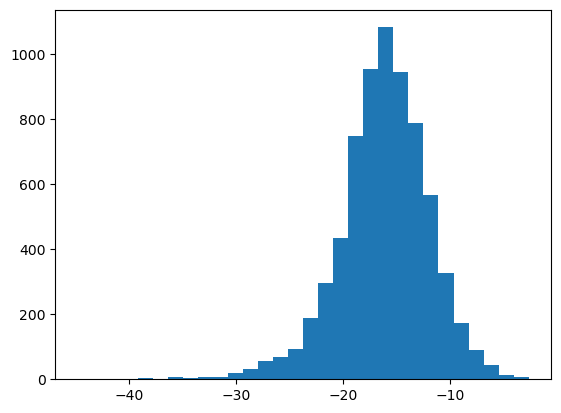

In [80]:
plt.hist(np.log2(dispersion_index.loc[dfreg.index] * np.exp(dfreg.NMD)), bins=30)

(array([1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        5.000e+00, 3.000e+00, 1.200e+01, 1.000e+01, 2.200e+01, 2.300e+01,
        4.800e+01, 5.800e+01, 7.800e+01, 1.100e+02, 1.710e+02, 2.730e+02,
        4.150e+02, 5.910e+02, 8.360e+02, 9.650e+02, 1.013e+03, 9.200e+02,
        6.420e+02, 4.170e+02, 1.890e+02, 9.500e+01, 3.600e+01, 1.200e+01]),
 array([-20.98420704, -20.28695868, -19.58971032, -18.89246195,
        -18.19521359, -17.49796523, -16.80071687, -16.1034685 ,
        -15.40622014, -14.70897178, -14.01172342, -13.31447506,
        -12.61722669, -11.91997833, -11.22272997, -10.52548161,
         -9.82823324,  -9.13098488,  -8.43373652,  -7.73648816,
         -7.03923979,  -6.34199143,  -5.64474307,  -4.94749471,
         -4.25024634,  -3.55299798,  -2.85574962,  -2.15850126,
         -1.4612529 ,  -0.76400453,  -0.06675617]),
 <BarContainer object of 30 artists>)

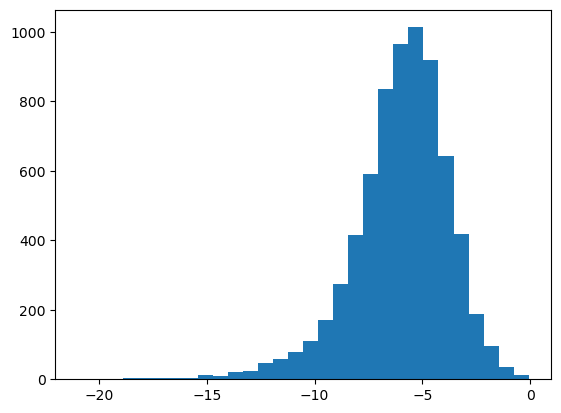

In [81]:
plt.hist(dfreg.NMD, bins=30)

(array([1.430e+02, 1.680e+02, 2.210e+02, 3.310e+02, 4.100e+02, 4.920e+02,
        5.460e+02, 6.860e+02, 7.250e+02, 9.050e+02, 9.470e+02, 1.142e+03,
        1.156e+03, 1.186e+03, 9.730e+02, 6.910e+02, 4.100e+02, 1.990e+02,
        7.000e+01, 2.200e+01, 9.000e+00, 4.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 1.000e+00]),
 array([-2.22717365, -2.00082475, -1.77447585, -1.54812695, -1.32177805,
        -1.09542915, -0.86908025, -0.64273136, -0.41638246, -0.19003356,
         0.03631534,  0.26266424,  0.48901314,  0.71536204,  0.94171094,
         1.16805984,  1.39440873,  1.62075763,  1.84710653,  2.07345543,
         2.29980433,  2.52615323,  2.75250213,  2.97885103,  3.20519993,
         3.43154882,  3.65789772,  3.88424662,  4.11059552,  4.33694442,
         4.56329332]),
 <BarContainer object of 30 artists>)

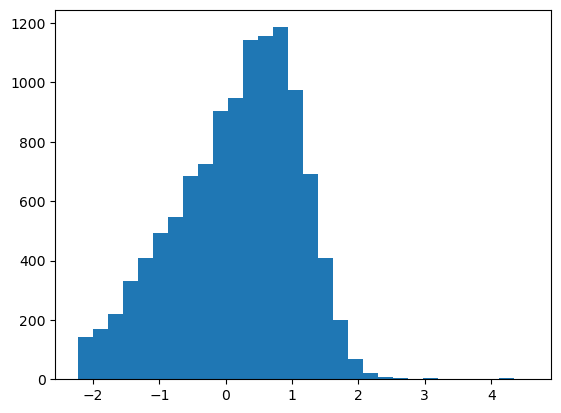

In [82]:
plt.hist(np.log(NMD_percent.mean(axis=1)/NMD_percent.std(axis=1)), bins=30)

In [83]:
# np.log(NMD_percent.mean(axis=1)/NMD_percent.std(axis=1)).loc[srsf_ensembl]

In [84]:
np.log(dispersion_index.loc[dfreg.index] * np.exp(dfreg.NMD)).loc[srsf_ensembl.intersection(dfreg.index)]

ENSG00000188529    -8.940619
ENSG00000116350    -6.741114
ENSG00000116754   -10.435567
ENSG00000115875    -9.687169
ENSG00000112081   -10.587253
ENSG00000111786   -11.723613
ENSG00000100650   -13.472731
ENSG00000136450   -10.144672
ENSG00000161547    -6.791840
ENSG00000124193   -10.503673
dtype: float64

In [85]:
srsf_ensembl

Index(['ENSG00000188529', 'ENSG00000116350', 'ENSG00000116754',
       'ENSG00000115875', 'ENSG00000112081', 'ENSG00000154548',
       'ENSG00000111786', 'ENSG00000100650', 'ENSG00000136450',
       'ENSG00000161547', 'ENSG00000124193'],
      dtype='object')

In [86]:
dfreg['mean_v_std'] = np.log2(NMD_percent.mean(axis=1)/NMD_percent.std(axis=1)).loc[dfreg.index]
dfreg['dispersion'] = dispersion_index.loc[dfreg.index]

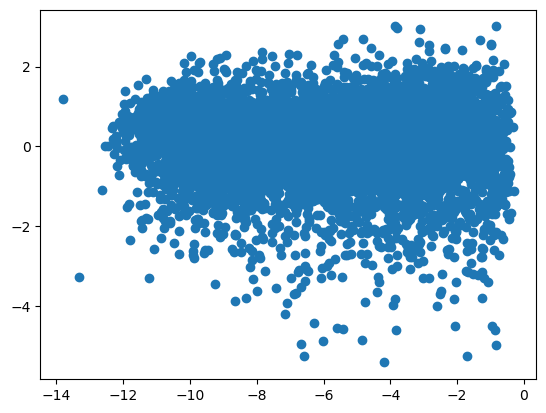

In [87]:
plt.scatter(data=dfreg, x='log_s_het', y='resid')

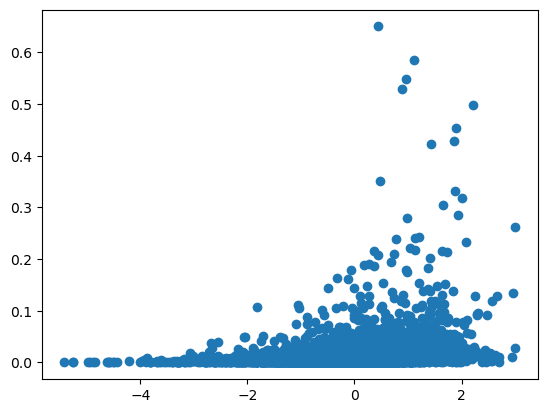

In [88]:
plt.scatter(data=dfreg, y='dispersion', x='resid')

(array([3.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 9.000e+00,
        8.000e+00, 1.700e+01, 2.000e+01, 2.900e+01, 4.600e+01, 6.400e+01,
        8.000e+01, 1.250e+02, 1.870e+02, 2.400e+02, 4.160e+02, 6.550e+02,
        8.020e+02, 9.680e+02, 1.002e+03, 8.390e+02, 6.250e+02, 3.870e+02,
        2.350e+02, 9.400e+01, 6.200e+01, 1.600e+01, 9.000e+00, 4.000e+00]),
 array([-5.41926102, -5.14121669, -4.86317236, -4.58512803, -4.3070837 ,
        -4.02903937, -3.75099504, -3.47295071, -3.19490637, -2.91686204,
        -2.63881771, -2.36077338, -2.08272905, -1.80468472, -1.52664039,
        -1.24859606, -0.97055173, -0.6925074 , -0.41446306, -0.13641873,
         0.1416256 ,  0.41966993,  0.69771426,  0.97575859,  1.25380292,
         1.53184725,  1.80989158,  2.08793592,  2.36598025,  2.64402458,
         2.92206891]),
 <BarContainer object of 30 artists>)

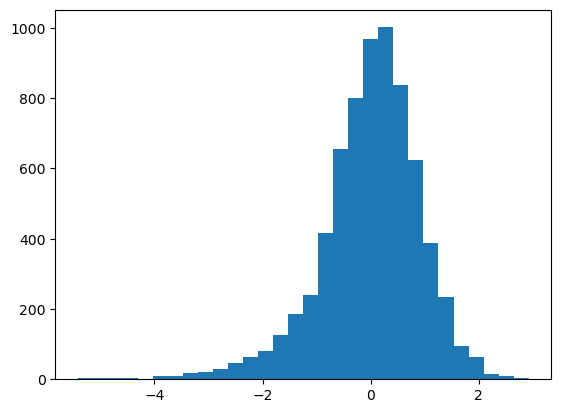

In [89]:
plt.hist(dfreg.resid*(1-dfreg.dispersion), bins=30)

(array([3.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 9.000e+00,
        9.000e+00, 1.800e+01, 2.000e+01, 3.500e+01, 4.500e+01, 6.800e+01,
        8.300e+01, 1.400e+02, 1.970e+02, 2.790e+02, 4.380e+02, 7.070e+02,
        8.160e+02, 1.003e+03, 9.700e+02, 7.980e+02, 5.790e+02, 3.430e+02,
        1.990e+02, 9.900e+01, 5.300e+01, 1.700e+01, 1.000e+01, 4.000e+00]),
 array([-5.41948571, -5.13869575, -4.85790578, -4.57711582, -4.29632586,
        -4.01553589, -3.73474593, -3.45395596, -3.173166  , -2.89237604,
        -2.61158607, -2.33079611, -2.05000614, -1.76921618, -1.48842621,
        -1.20763625, -0.92684629, -0.64605632, -0.36526636, -0.08447639,
         0.19631357,  0.47710353,  0.7578935 ,  1.03868346,  1.31947343,
         1.60026339,  1.88105335,  2.16184332,  2.44263328,  2.72342325,
         3.00421321]),
 <BarContainer object of 30 artists>)

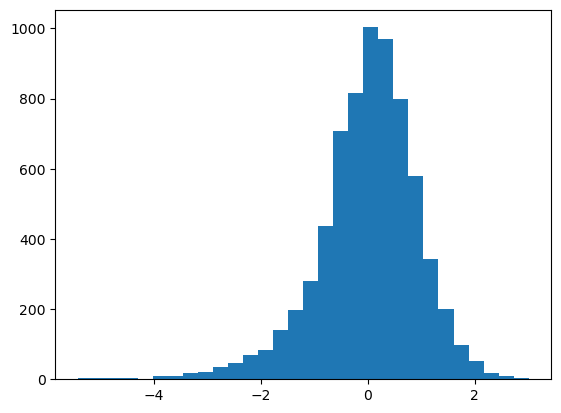

In [90]:
plt.hist(dfreg.resid, bins=30)

In [91]:
counts_by_junction = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(NMD_annot)
].groupby(['gene', 'junction']).Count.sum().reset_index()

In [92]:
from scipy.stats import entropy


In [93]:
gene_count_groups = counts_by_junction.groupby('gene')
def calculate_entropy(counts):
    probabilities = counts / np.sum(counts)
    return entropy(probabilities, base=2)


In [94]:
entropy_df = gene_count_groups['Count'].apply(calculate_entropy).reset_index()
entropy_df.columns = ['genes', 'entropy']


In [95]:
entropy_df = entropy_df.sort_values('entropy', ascending=False)
entropy_df.index = [x.split('.')[0] for x in entropy_df.genes]

In [96]:
NMD_percent.mean(axis=1)

ENSG00000188976    0.030217
ENSG00000187961    0.074475
ENSG00000187583    0.012371
ENSG00000188290    0.024311
ENSG00000188157    0.003661
                     ...   
ENSG00000148399    0.251680
ENSG00000165724    0.058806
ENSG00000197070    0.009169
ENSG00000181090    0.031994
ENSG00000148408    0.015517
Length: 11449, dtype: float64

In [97]:
shared_idx = NMD_percent.index.intersection(entropy_df.index)

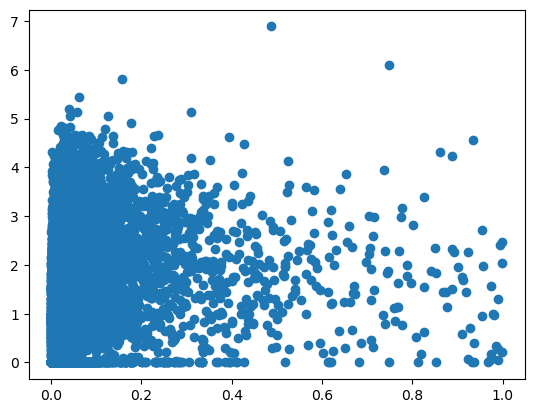

In [98]:
plt.scatter(NMD_percent.mean(axis=1).loc[shared_idx], entropy_df.loc[shared_idx].entropy)

/project2/mstephens/cfbuenabadn/anaconda3/envs/jnotebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


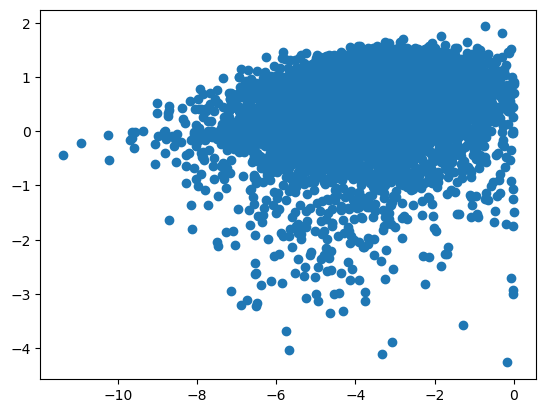

In [99]:
plt.scatter(np.log(NMD_percent.mean(axis=1).loc[shared_idx]), 
            np.log(entropy_df.loc[shared_idx].entropy))

In [100]:
entropy_df.loc[shared_idx]

genes   entropy
ENSG00000188976  ENSG00000188976.11  1.487935
ENSG00000187961  ENSG00000187961.14  2.265625
ENSG00000187583  ENSG00000187583.11  0.925940
ENSG00000188290  ENSG00000188290.11  0.000000
ENSG00000188157  ENSG00000188157.15  2.351937
...                             ...       ...
ENSG00000148399  ENSG00000148399.13  2.772656
ENSG00000165724   ENSG00000165724.6  0.753266
ENSG00000197070  ENSG00000197070.14  1.602415
ENSG00000181090  ENSG00000181090.21  4.033426
ENSG00000148408  ENSG00000148408.13  0.933357

[11449 rows x 2 columns]

In [101]:
# np.log((NMD_percent.mean(axis=1) * 1/(1+entropy_df.loc[shared_idx].entropy)).sort_values()).loc[srsf_ensembl]

In [102]:
entropy_weighted_NMD = np.log2((NMD_percent.mean(axis=1) * 1/(1+entropy_df.loc[shared_idx].entropy)).sort_values())

In [103]:
dfreg['weighted_NMD'] = entropy_weighted_NMD.loc[dfreg.index]

<Axes: xlabel='RPKM', ylabel='weighted_NMD'>

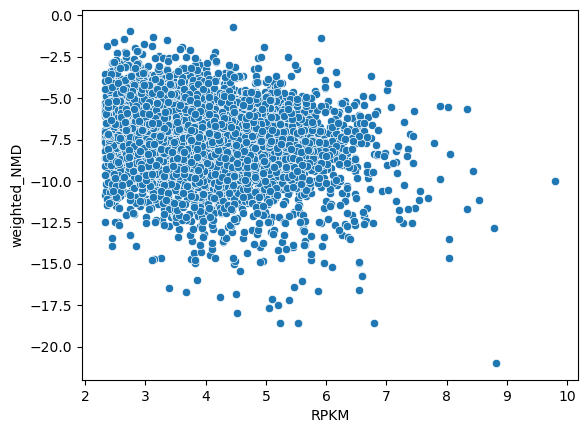

In [104]:
sns.scatterplot(data=dfreg, x='RPKM', y='weighted_NMD')

In [105]:
dfreg.loc[srsf_ensembl.intersection(dfreg.index)]

RPKM  gene_length  log_s_het       NMD     zRPKM  \
ENSG00000188529  5.988190    14.017243  -3.514383 -2.810936  2.113439   
ENSG00000116350  5.420312    15.059936  -1.865911 -1.910245  1.542919   
ENSG00000116754  6.631781    15.531717  -0.938073 -3.624016  2.760024   
ENSG00000115875  5.885160    12.946906  -1.303513 -4.304184  2.009930   
ENSG00000112081  5.279779    13.457381  -0.497929 -5.849631  1.401732   
ENSG00000111786  5.019690    12.979604  -2.094252 -7.039763  1.140434   
ENSG00000100650  5.418160    15.461032  -2.247529 -6.869270  1.540757   
ENSG00000136450  5.681458    12.650154  -0.670696 -4.733672  1.805280   
ENSG00000161547  7.023083    11.652397  -3.153358 -2.574363  3.153146   
ENSG00000124193  5.519536    12.993292  -2.540875 -4.714692  1.642605   

                 zgene_length  zlog_s_het      zNMD     resid  zNMD_pred  \
ENSG00000188529     -0.680803    0.756505  1.428931  2.083385  -0.654454   
ENSG00000116350     -0.037484    1.322848  1.832805  2.422058  -0.589253   
ENSG00000116754      0.253594    1.641613  1.064342  1.901686  -0.837345   
ENSG00000115875     -1.341177    1.516064  0.759351  1.670695  -0.911344   
ENSG00000112081     -1.026225    1.792827  0.066364  0.887036  -0.820671   
ENSG00000111786     -1.321003    1.244400 -0.467297  0.222657  -0.689954   
ENSG00000100650      0.209983    1.191741 -0.390847  0.130656  -0.521503   
ENSG00000136450     -1.524266    1.733472  0.566766  1.519555  -0.952789   
ENSG00000161547     -2.139860    0.880538  1.535011  2.620609  -1.085598   
ENSG00000124193     -1.312558    1.090960  0.575277  1.317707  -0.742431   

                gene_name  exon_count  mean_v_std  dispersion  weighted_NMD  
ENSG00000188529    SRSF10           6    3.016163    0.002177     -3.904647  
ENSG00000116350     SRSF4           6    2.529613    0.007980     -3.685966  
ENSG00000116754    SRSF11          13    3.101488    0.001101     -5.431142  
ENSG00000115875     SRSF7           8    1.730911    0.004594     -5.648862  
ENSG00000112081     SRSF3           6    0.492656    0.008759     -7.041446  
ENSG00000111786     SRSF9           4   -0.141198    0.009243     -7.169640  
ENSG00000100650     SRSF5           9    1.328755    0.001356     -7.919113  
ENSG00000136450     SRSF1           5    1.536375    0.004467     -6.124267  
ENSG00000161547     SRSF2           3    1.755086    0.014736     -4.062224  
ENSG00000124193     SRSF6           7    1.818521    0.003061     -5.493887

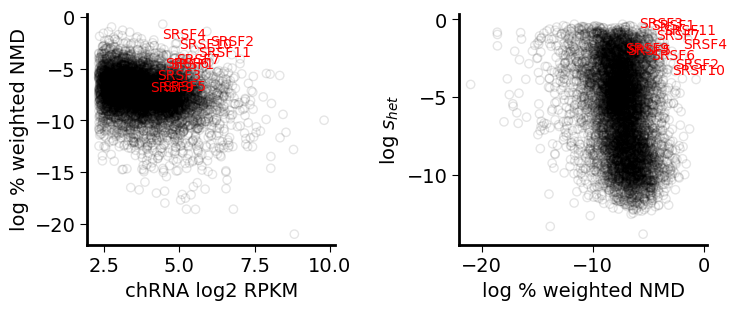

In [106]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.RPKM, dfreg.weighted_NMD, **kwargs)
for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
    ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='red', size=10)
    
ax[1].scatter(dfreg.weighted_NMD, dfreg.log_s_het, **kwargs)
for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
    ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='red', size=10)



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % weighted NMD', size=14)

ax[1].set_xlabel('log % weighted NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

In [107]:
dfreg['z_wNMD'] = zscore(dfreg.weighted_NMD)

In [108]:
model, r2, y_pred = run_regression(dfreg, ['zRPKM', 'zlog_s_het', 'zgene_length'], 'z_wNMD')
model.resid.loc[srsf_ensembl.intersection(dfreg.index)]

ENSG00000188529    2.347102
ENSG00000116350    2.458412
ENSG00000116754    1.869179
ENSG00000115875    1.617814
ENSG00000112081    0.851695
ENSG00000111786    0.626327
ENSG00000100650    0.285789
ENSG00000136450    1.387860
ENSG00000161547    2.515774
ENSG00000124193    1.536072
dtype: float64

(array([1.000e+00, 1.000e+00, 2.000e+00, 7.000e+00, 4.000e+00, 3.000e+00,
        1.000e+01, 1.500e+01, 1.600e+01, 2.900e+01, 5.400e+01, 6.400e+01,
        1.170e+02, 1.800e+02, 2.700e+02, 4.450e+02, 7.650e+02, 9.810e+02,
        1.091e+03, 1.014e+03, 7.740e+02, 4.830e+02, 2.970e+02, 1.770e+02,
        8.900e+01, 3.600e+01, 1.800e+01, 5.000e+00, 4.000e+00, 2.000e+00]),
 array([-5.77552725, -5.46028769, -5.14504812, -4.82980856, -4.51456899,
        -4.19932943, -3.88408986, -3.5688503 , -3.25361073, -2.93837117,
        -2.6231316 , -2.30789204, -1.99265247, -1.67741291, -1.36217334,
        -1.04693378, -0.73169421, -0.41645465, -0.10121508,  0.21402449,
         0.52926405,  0.84450362,  1.15974318,  1.47498275,  1.79022231,
         2.10546188,  2.42070144,  2.73594101,  3.05118057,  3.36642014,
         3.6816597 ]),
 <BarContainer object of 30 artists>)

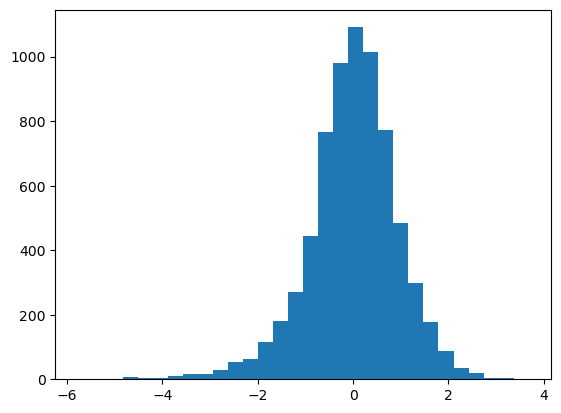

In [109]:
plt.hist(model.resid, bins=30)

In [110]:
dfreg['wResid'] = model.resid
dfreg['z_wNMD_pred'] = y_pred

In [111]:
dfreg.to_csv('../../nmd_pred.tab.gz', sep='\t', header=True, index=True)

In [112]:
m2h = pd.read_csv('../../m2h.tab.gz', sep='\t')
annotation = pd.read_csv('/project2/yangili1/cfbuenabadn/1-s2.0-S1097276517300370-mmc3.tab', sep='\t')
tf_mouse_ensembl = annotation.loc[annotation.Group.isin(['Chromatin/TF', 'Overlap'])].EnsemblGeneID
sf_mouse_ensembl = annotation.loc[annotation.Group.isin(['Splicing factor/RBP', 'Overlap'])].EnsemblGeneID
tf_sf_mouse_ensembl = annotation.loc[annotation.Group.isin(['Overlap'])].EnsemblGeneID
human_sf = list(m2h.loc[m2h.ensembl_gene_id.isin(sf_mouse_ensembl)].hsapiens_homolog_associated_gene_name)
human_tf = list(m2h.loc[m2h.ensembl_gene_id.isin(tf_mouse_ensembl)].hsapiens_homolog_associated_gene_name)
human_tf_sf = list(m2h.loc[m2h.ensembl_gene_id.isin(tf_sf_mouse_ensembl)].hsapiens_homolog_associated_gene_name)

hnrnp = [x for x in human_sf if x[:5] == 'HNRNP']
srsf = [x for x in human_sf if x[:4] == 'SRSF']
other = [x for x in human_sf if x[:4] == 'NOVA']
other += [x for x in human_sf if x[:4] == 'PTBP']
other += [x for x in human_sf if x[:5] == 'RBFOX']
other += [x for x in human_sf if x[:4] == 'MBNL']
other += [x for x in human_sf if x[:4] == 'SRRM']
other += [x for x in human_sf if x[:5] == 'ELAVL']
other += [x for x in human_sf if x[:3] == 'RBM']

In [113]:
sf_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(human_sf)].hsapiens_homolog_ensembl_gene)

srsf_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(srsf)].hsapiens_homolog_ensembl_gene)
hnrnp_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(hnrnp)].hsapiens_homolog_ensembl_gene)
other_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(other)].hsapiens_homolog_ensembl_gene)

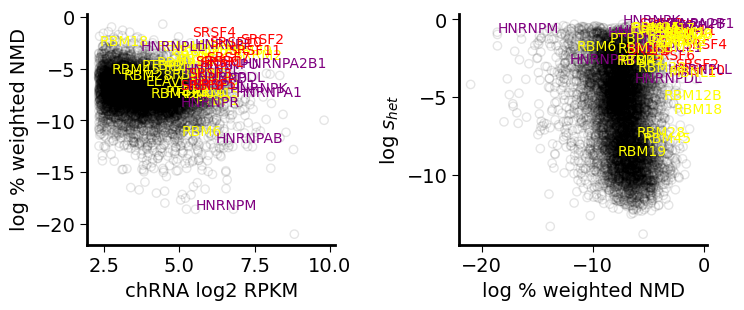

In [114]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.RPKM, dfreg.weighted_NMD, **kwargs)

counts = 1

# for idx, row in dfreg.iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM, row.NMD), c='gray', size=10)
# #     if counts > 500:
# #         break
# #     counts += 1
    
    
for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
    ax[0].annotate(row.gene_name, (row.RPKM, row.NMD), c='yellow', size=10)

for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
    ax[0].annotate(row.gene_name, (row.RPKM, row.NMD), c='purple', size=10)


    
for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
    ax[0].annotate(row.gene_name, (row.RPKM, row.NMD), c='red', size=10)
    
ax[1].scatter(dfreg.weighted_NMD, dfreg.log_s_het, **kwargs)
for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
    ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='red', size=10)
    
for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
    ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='purple', size=10)
    
for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
    ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='yellow', size=10)



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % weighted NMD', size=14)

ax[1].set_xlabel('log % weighted NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

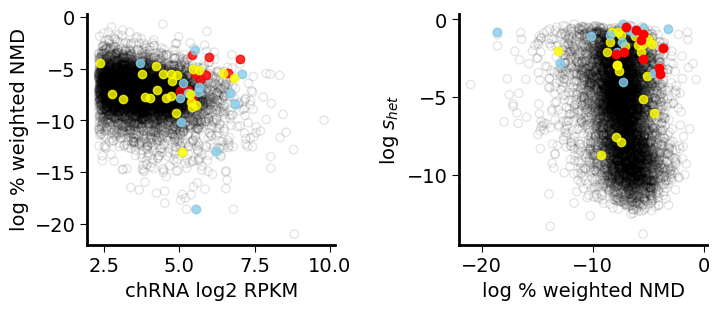

In [115]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.RPKM, dfreg.weighted_NMD, **kwargs)

ax[0].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].weighted_NMD, c='red', alpha=0.8)

ax[0].scatter(dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].weighted_NMD, c='skyblue', alpha=0.8)

ax[0].scatter(dfreg.loc[other_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[other_ensembl.intersection(dfreg.index)].weighted_NMD, c='yellow', alpha=0.8)

# for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='red', size=10)

# for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='purple', size=10)

# for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='yellow', size=10)
    
ax[1].scatter(dfreg.weighted_NMD, dfreg.log_s_het, **kwargs)






ax[1].scatter(dfreg.loc[other_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[other_ensembl.intersection(dfreg.index)].log_s_het, c='yellow', alpha=0.8)

ax[1].scatter(dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].log_s_het, c='skyblue', alpha=0.8)

ax[1].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].log_s_het, c='red')
# for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
#     ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='red', size=10)
    
# for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
#     ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='purple', size=10)
    
# for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
#     ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='yellow', size=10)



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % weighted NMD', size=14)

ax[1].set_xlabel('log % weighted NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

In [116]:
NMD_SF = srsf + ['HNRNP2B1','FUS','HNRNPD','HNRNPDL','PTBP1','PTBP2','RBFOX2','HNRNPH1','HNRNPH3','RBM10','RBM25','RBM5',
                 'HNRNPK','HNRNPL','HNRNPLL','SF1','SF3B1','SFPQ','HNRNPM','SNRNP70','SREK1','SRRM1',
                 'TIA1','TIAL1','TRA2A','TRA2B','U2AF1','U2AF2']
nmd_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(NMD_SF)].hsapiens_homolog_ensembl_gene)

In [117]:
pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name == 'UPF1'].hsapiens_homolog_ensembl_gene)

Index(['ENSG00000005007'], dtype='object', name='hsapiens_homolog_ensembl_gene')

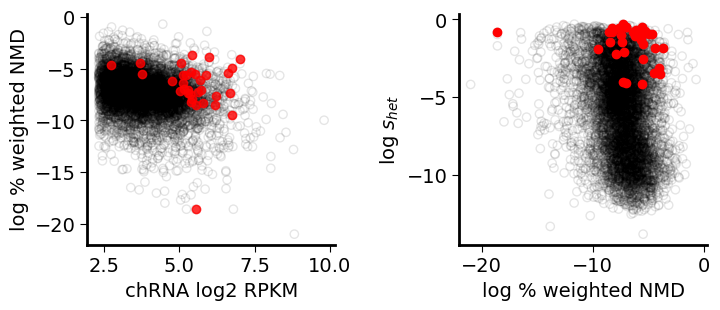

In [118]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.RPKM, dfreg.weighted_NMD, **kwargs)

ax[0].scatter(dfreg.loc[nmd_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[nmd_ensembl.intersection(dfreg.index)].weighted_NMD, c='red', alpha=0.8)


# for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='red', size=10)

# for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='purple', size=10)

# for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='yellow', size=10)
    
ax[1].scatter(dfreg.weighted_NMD, dfreg.log_s_het, **kwargs)

ax[1].scatter(dfreg.loc[nmd_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[nmd_ensembl.intersection(dfreg.index)].log_s_het, c='red')



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % weighted NMD', size=14)

ax[1].set_xlabel('log % weighted NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

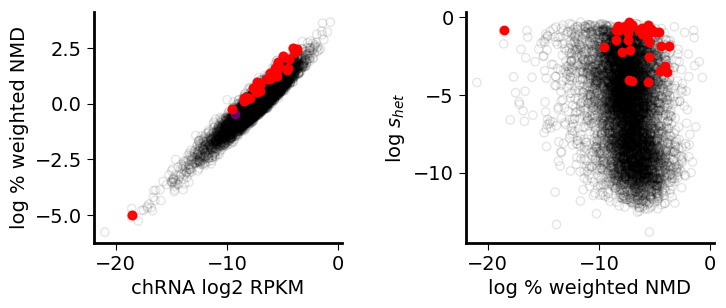

In [119]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.weighted_NMD, dfreg.wResid, **kwargs)

ax[0].scatter(dfreg.loc[nmd_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[nmd_ensembl.intersection(dfreg.index)].wResid, c='red', alpha=0.8)

ax[0].scatter(dfreg.loc['ENSG00000005007'].weighted_NMD, 
              dfreg.loc['ENSG00000005007'].wResid, c='purple', alpha=0.8)



ax[0].scatter(dfreg.loc[nmd_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[nmd_ensembl.intersection(dfreg.index)].wResid, c='red', alpha=0.8)


# for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='red', size=10)

# for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='purple', size=10)

# for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='yellow', size=10)
    
ax[1].scatter(dfreg.weighted_NMD, dfreg.log_s_het, **kwargs)

ax[1].scatter(dfreg.loc[nmd_ensembl.intersection(dfreg.index)].weighted_NMD, 
              dfreg.loc[nmd_ensembl.intersection(dfreg.index)].log_s_het, c='red')



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % weighted NMD', size=14)

ax[1].set_xlabel('log % weighted NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

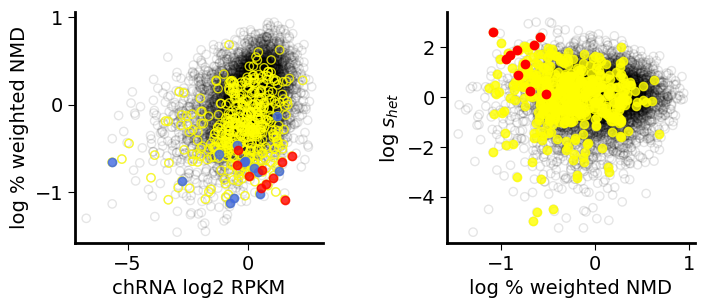

In [120]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.zNMD, dfreg.zNMD_pred, **kwargs)

ax[0].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].zNMD, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].zNMD_pred, facecolor='none', edgecolor ='yellow', 
              alpha=0.8)

ax[0].scatter(dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].zNMD, 
              dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].zNMD_pred, c='royalblue', alpha=0.8)



ax[0].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].zNMD, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].zNMD_pred, c='red', alpha=0.8)



# ax[0].scatter(dfreg.loc['ENSG00000005007'].z_wNMD, 
#               dfreg.loc['ENSG00000005007'].z_wNMD_pred, c='purple', alpha=0.8)



# ax[0].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].z_wNMD, 
#               dfreg.loc[nmd_ensembl.intersection(dfreg.index)].z_wNMD_pred, c='red', alpha=0.8)


# for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='red', size=10)

# for idx, row in dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='purple', size=10)

# for idx, row in dfreg.loc[other_ensembl.intersection(dfreg.index)].iterrows():
#     ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='yellow', size=10)
    
ax[1].scatter(dfreg.zNMD_pred, dfreg.resid, **kwargs)

ax[1].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].zNMD_pred, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].resid, c='yellow', alpha=0.8)

ax[1].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].zNMD_pred, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].resid, c='red')



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % weighted NMD', size=14)

ax[1].set_xlabel('log % weighted NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

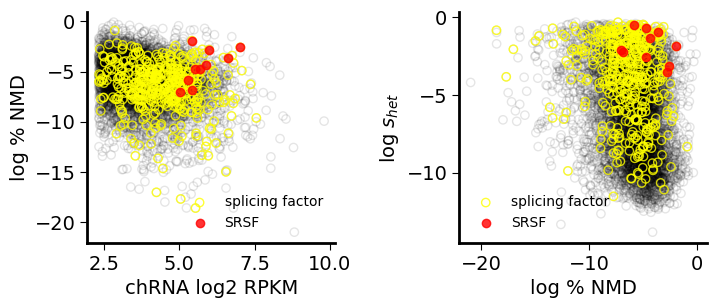

In [121]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.RPKM, dfreg.NMD, **kwargs)

ax[0].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].NMD, facecolor='none', edgecolor ='yellow', 
              alpha=0.8, label='splicing factor')

ax[0].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].NMD, c='red', alpha=0.8, label='SRSF')

ax[0].legend(frameon=False)

    
ax[1].scatter(dfreg.NMD, dfreg.log_s_het, **kwargs)
ax[1].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].NMD, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].log_s_het, facecolor='none', edgecolor ='yellow', 
              alpha=0.8, label='splicing factor')

ax[1].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].NMD, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].log_s_het, c='red', alpha=0.8, label='SRSF')


ax[1].legend(frameon=False)


for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log % NMD', size=14)

ax[1].set_xlabel('log % NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

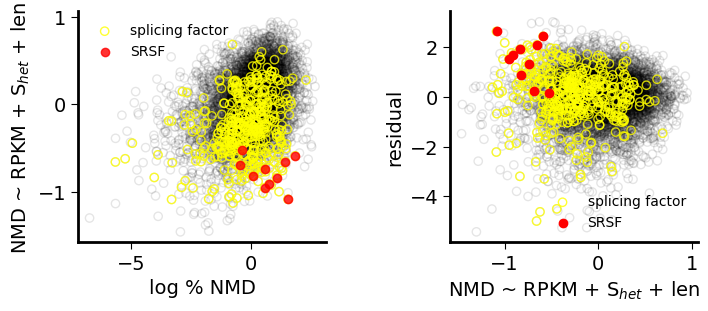

In [122]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.zNMD, dfreg.zNMD_pred, **kwargs)

ax[0].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].zNMD, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].zNMD_pred, facecolor='none', edgecolor ='yellow', 
              alpha=0.8, label='splicing factor')

# ax[0].scatter(dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].zNMD, 
#               dfreg.loc[hnrnp_ensembl.intersection(dfreg.index)].zNMD_pred, c='royalblue', alpha=0.8)



ax[0].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].zNMD, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].zNMD_pred, c='red', alpha=0.8, label='SRSF')

ax[0].legend(frameon=False)

ax[1].scatter(dfreg.zNMD_pred, dfreg.resid, **kwargs)

ax[1].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].zNMD_pred, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].resid, facecolor='none', edgecolor ='yellow', alpha=0.8,
             label='splicing factor')

ax[1].scatter(dfreg.loc[srsf_ensembl.intersection(dfreg.index)].zNMD_pred, 
              dfreg.loc[srsf_ensembl.intersection(dfreg.index)].resid, c='red', label='SRSF')

ax[1].legend(frameon=False)


# ax[1].plot([-1.2, 1.2], [0.597290, 0.597290], c='red', linestyle='--')
# ax[1].plot([-0.236873, -0.236873], [-4.5, 2.5], c='red', linestyle='--')


for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('log % NMD', size=14)
ax[0].set_ylabel('NMD ~ RPKM + S$_{het}$ + len', size=14)

ax[1].set_xlabel('NMD ~ RPKM + S$_{het}$ + len', size=14)
ax[1].set_ylabel('residual', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

In [123]:
gene_list = list(dfreg.loc[(dfreg.resid > 0.597290 ) & (dfreg.zNMD_pred<-0.236873)].gene_name)

In [124]:
gene_list = list(dfreg.loc[(dfreg.zNMD > 0.650403 ) & (dfreg.zNMD_pred<-0.236873)].gene_name)

In [125]:
gene_list = list(dfreg.loc[(dfreg.zNMD > 0.650403 ) & (dfreg.log_s_het>-2.447538) & (dfreg.RPKM>6.306430)].gene_name)

In [126]:
gene_list = list(dfreg.loc[(dfreg.zNMD > 0.108868 ) & (dfreg.log_s_het>-3.945871) & (dfreg.RPKM>5.135497)].gene_name)

In [127]:
def filter_by_quartile(df, feature, quartile='50%', top=True):
    q = df.describe().loc[quartile, feature]
    if top:
        df_q = df.loc[df[feature]>q]
    else:
        df_q = df.loc[df[feature]<=q]
    
    return df_q

In [128]:
dfreg = pd.DataFrame()
dfreg['RPKM'] = df_scores.RPKM
dfreg['gene_length'] = np.array(df_scores.gene_length)
dfreg['log_s_het'] = np.array(df_scores.log_s_het)
dfreg['NMD'] = np.array(df_scores.NMD)

# dfreg = dfreg.loc[dfreg.RPKM > np.log2(5)]

dfreg['zRPKM'] = zscore(df_scores.loc[dfreg.index].RPKM)
dfreg['zgene_length'] = zscore(df_scores.loc[dfreg.index].gene_length)
dfreg['zlog_s_het'] = zscore(df_scores.loc[dfreg.index].log_s_het)
dfreg['zNMD'] = zscore(df_scores.loc[dfreg.index].NMD)

dfreg = dfreg.merge(genes_exons, right_index=True, left_index=True)

In [129]:
top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='50%')

top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='75%')
top_s = filter_by_quartile(dfreg, 'log_s_het', quartile='75%')
top_top_ = top_expressed.index.intersection(top_s.index)
top_nmd_ = filter_by_quartile(dfreg.loc[top_top_], 'NMD', quartile='75%')

In [130]:
top_nmd_

RPKM  gene_length  log_s_het       NMD     zRPKM  \
ENSG00000001629  4.695919    17.245720  -2.845645 -4.646308  0.925141   
ENSG00000004866  4.349442    18.078828  -3.545310 -4.774020  0.793353   
ENSG00000010322  4.245123    15.211850  -3.791476 -5.243906  0.753673   
ENSG00000011454  4.257187    17.323635  -1.803854 -4.992277  0.758262   
ENSG00000011590  5.916089    13.607446  -3.101131 -1.030827  1.389253   
...                   ...          ...        ...       ...       ...   
ENSG00000239306  4.930454    13.700115  -2.067392 -4.445802  1.014350   
ENSG00000241553  4.413265    13.894818  -1.447815 -3.431021  0.817629   
ENSG00000254999  4.153490    13.491352  -2.744948 -2.961309  0.718819   
ENSG00000255302  4.451921    10.994353  -3.864737 -0.699591  0.832332   
ENSG00000275052  4.717999    16.127450  -3.714860 -4.009472  0.933540   

                 zgene_length  zlog_s_het      zNMD gene_name  exon_count  
ENSG00000001629      1.193719    1.160622  0.418762    ANKIB1          20  
ENSG00000004866      1.674716    0.930289  0.362561       ST7          16  
ENSG00000010322      0.019461    0.849250  0.155782     NISCH          22  
ENSG00000011454      1.238704    1.503583  0.266514   RABGAP1          26  
ENSG00000011590     -0.906846    1.076515  2.009794    ZBTB32           7  
...                       ...         ...       ...       ...         ...  
ENSG00000239306     -0.853343    1.416826  0.506997     RBM14           3  
ENSG00000241553     -0.740931    1.620793  0.953562     ARPC4           6  
ENSG00000254999     -0.973873    1.193771  1.160264      BRK1           3  
ENSG00000255302     -2.415520    0.825133  2.155558      EID1           2  
ENSG00000275052      0.548084    0.874473  0.699009   PPP4R3B          17  

[304 rows x 10 columns]

In [131]:
gene_list = list(top_nmd_.gene_name)

In [132]:
dfreg.describe().loc['75%']

RPKM             4.026302
gene_length     16.373591
log_s_het       -3.874746
NMD             -4.118059
zRPKM            0.670441
zgene_length     0.690194
zlog_s_het       0.821838
zNMD             0.651224
exon_count      16.000000
Name: 75%, dtype: float64

In [133]:
[x for x in gene_list if x[:4]=='SRSF']

['SRSF7', 'SRSF4', 'SRSF11', 'SRSF6', 'SRSF1', 'SRSF2', 'SRSF10']

In [134]:
len(gene_list)

304

In [135]:
import gseapy as gp
from gseapy import barplot, dotplot


In [136]:
enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c2.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

2023-06-14 00:29:08,922 [INFO] User defined gene sets is given: ../../c2.all.v2023.1.Hs.symbols.gmt
2023-06-14 00:29:09,108 [INFO] Run: c2.all.v2023.1.Hs.symbols.gmt 
2023-06-14 00:29:12,709 [INFO] Background is not set! Use all 22109 genes in c2.all.v2023.1.Hs.symbols.gmt.
2023-06-14 00:29:19,099 [INFO] Done.


<Axes: title={'center': 'Important genes NMD Q4\nMSigDB C2 Pathways'}, xlabel='Odds Ratio'>

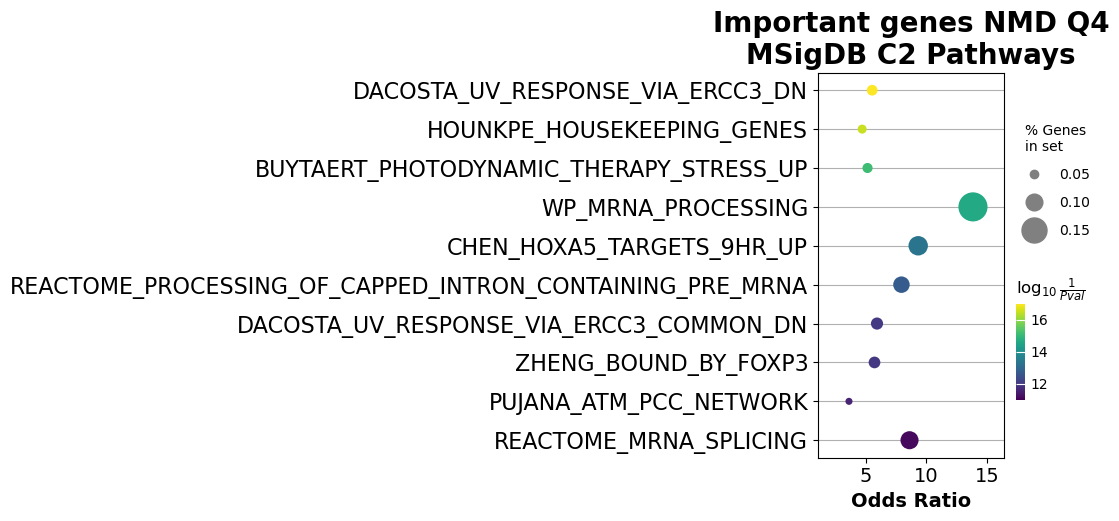

In [137]:
dotplot(enr2.res2d, title='Important genes NMD Q4\nMSigDB C2 Pathways',cmap='viridis', size=20, figsize=(3,5))

<Axes: title={'center': 'Important genes NMD Q4\nMSigDB C2 Pathways'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

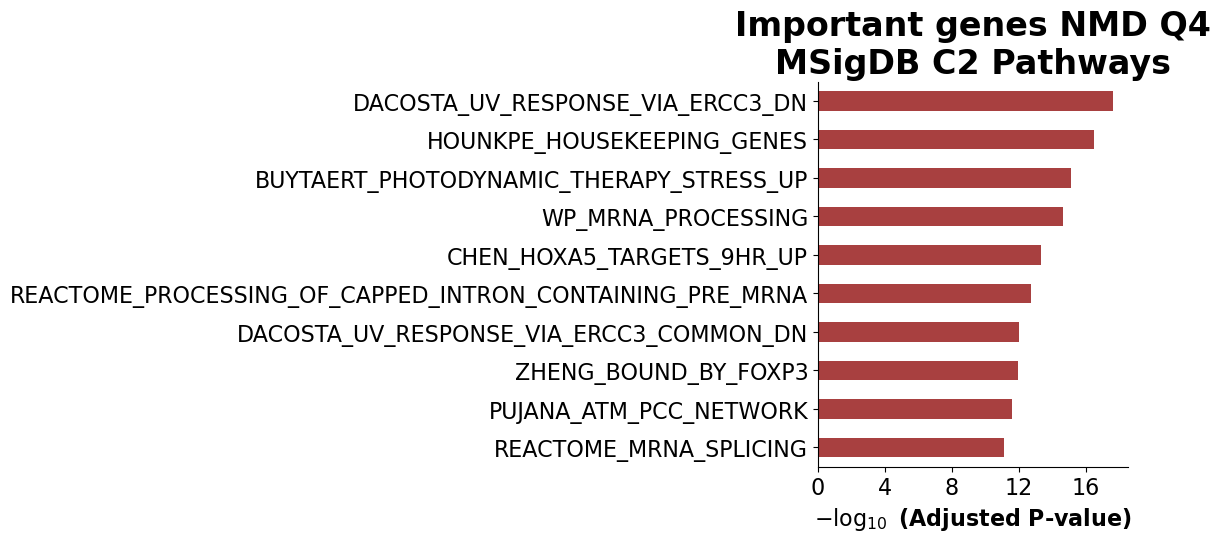

In [138]:
barplot(enr2.res2d,title='Important genes NMD Q4\nMSigDB C2 Pathways', figsize=(4, 5), color='darkred')


In [139]:
enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

2023-06-14 00:29:19,718 [INFO] User defined gene sets is given: ../../c5.all.v2023.1.Hs.symbols.gmt
2023-06-14 00:29:20,257 [INFO] Run: c5.all.v2023.1.Hs.symbols.gmt 
2023-06-14 00:29:28,868 [INFO] Background is not set! Use all 19384 genes in c5.all.v2023.1.Hs.symbols.gmt.
2023-06-14 00:29:39,211 [INFO] Done.


<Axes: title={'center': 'Important genes NMD Q4\nMSigDB C5 Ontology'}, xlabel='Odds Ratio'>

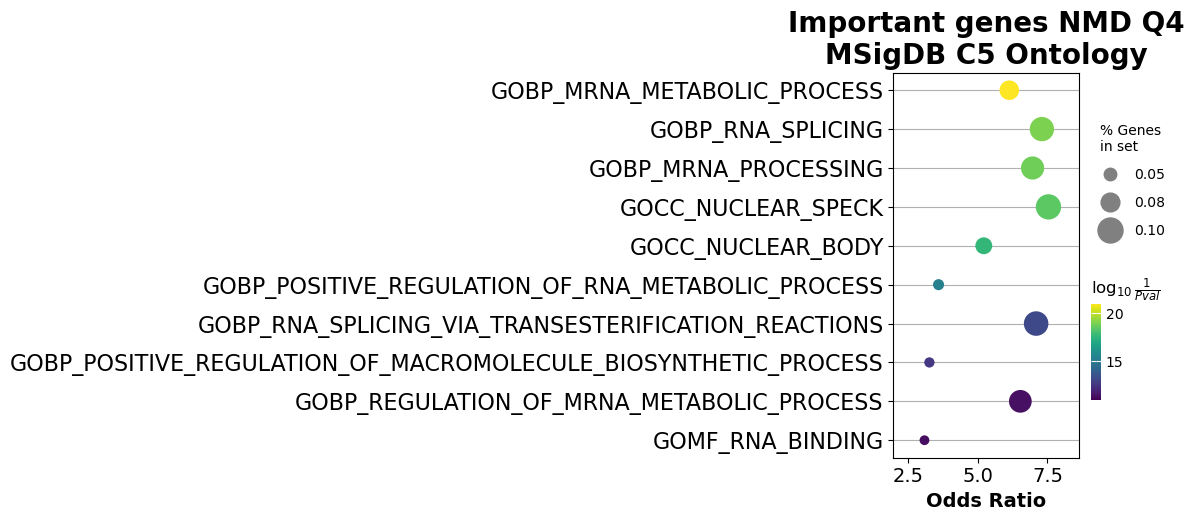

In [140]:
dotplot(enr2.res2d, title='Important genes NMD Q4\nMSigDB C5 Ontology',cmap='viridis', size=30, figsize=(3,5))

<Axes: title={'center': 'Important genes NMD Q4\nMSigDB C5 Ontology'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

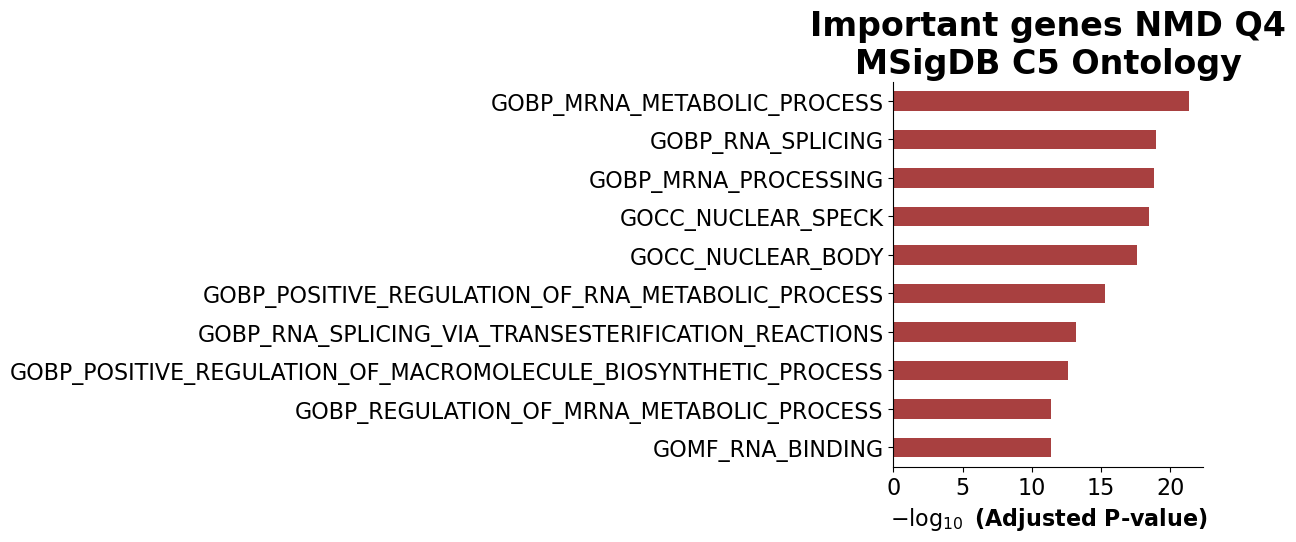

In [141]:
barplot(enr2.res2d,title='Important genes NMD Q4\nMSigDB C5 Ontology', figsize=(4, 5), color='darkred')


<Axes: title={'center': 'NMD_pred Q1, residual Q4'}, xlabel='Odds Ratio'>

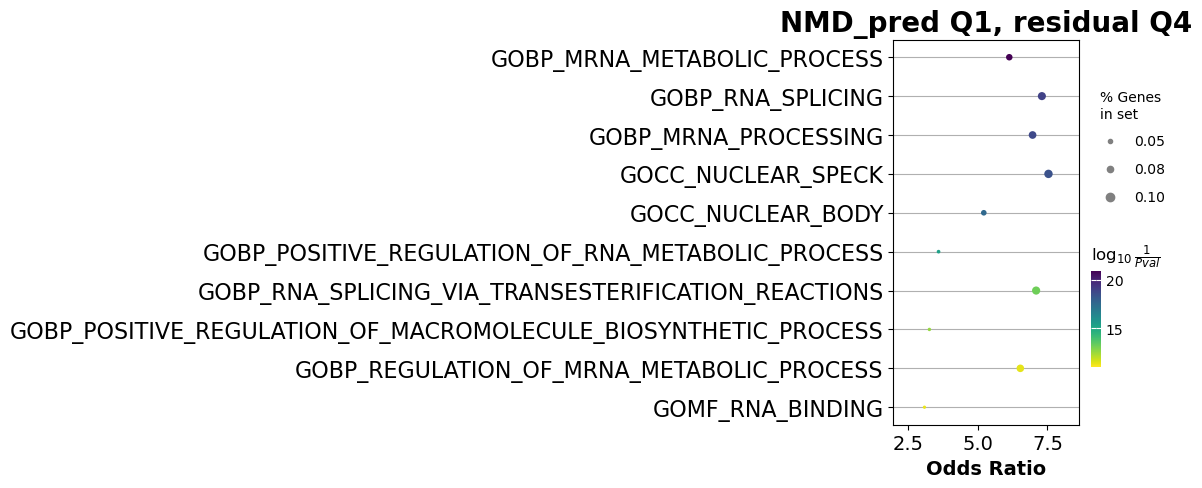

In [142]:
dotplot(enr2.res2d, title='NMD_pred Q1, residual Q4',cmap='viridis_r', size=10, figsize=(3,5))

<Axes: title={'center': 'NMD_pred Q1, NMD Q4'}, xlabel='Odds Ratio'>

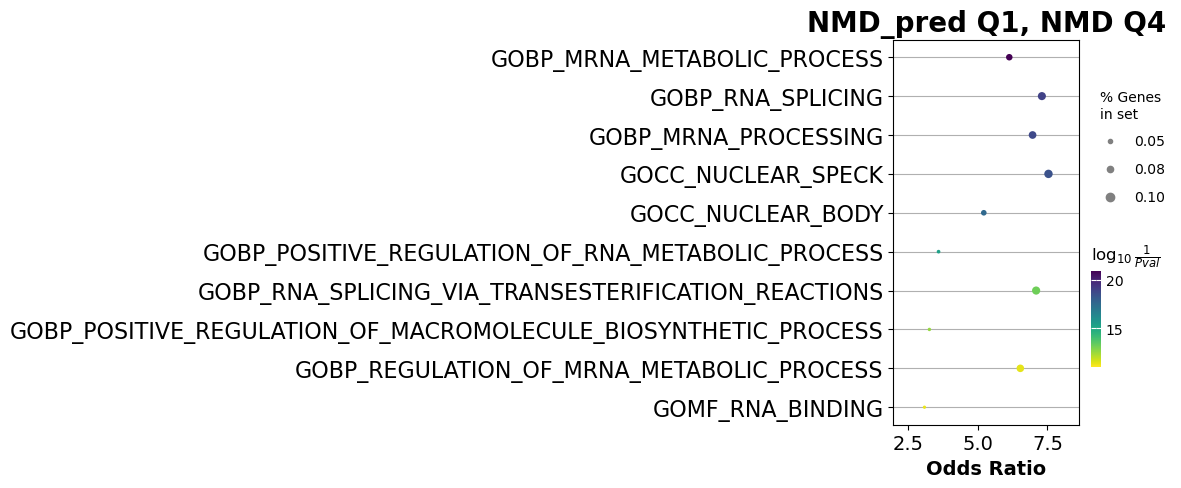

In [143]:
dotplot(enr2.res2d, title='NMD_pred Q1, NMD Q4',cmap='viridis_r', size=10, figsize=(3,5))

<Axes: title={'center': 'title'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

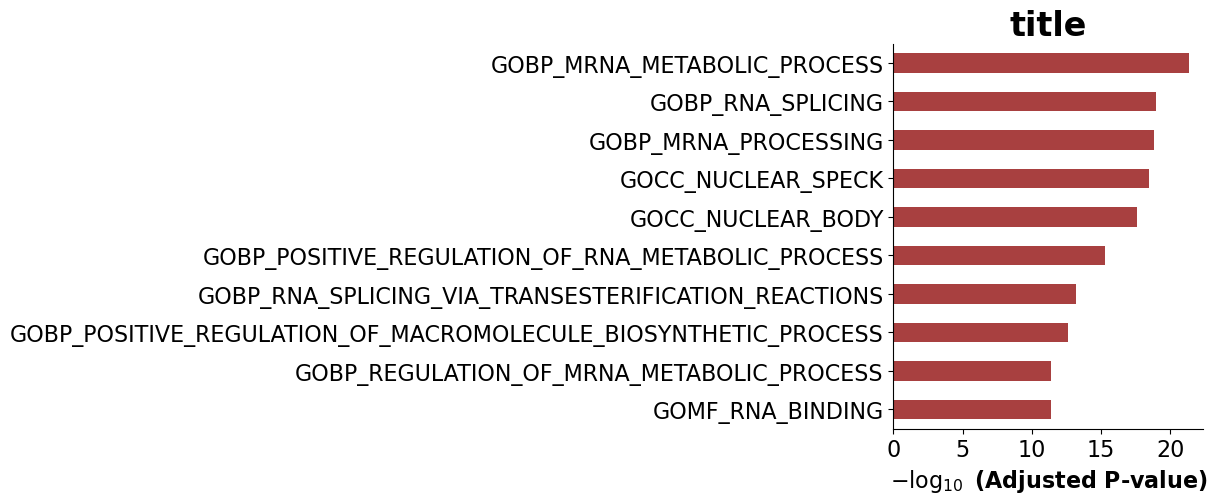

In [144]:
barplot(enr2.res2d,title='title', figsize=(4, 5), color='darkred')


In [145]:
pre_res = gp.prerank(rnk=dfreg.loc[top_top_,['gene_name', 'zNMD']], # or rnk = rnk,
                     gene_sets='../../c5.all.v2023.1.Hs.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2023-06-14 00:29:40,661 [INFO] Parsing data files for GSEA.............................
2023-06-14 00:29:41,133 [INFO] 11357 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-06-14 00:29:41,134 [INFO] 4580 gene_sets used for further statistical testing.....
2023-06-14 00:29:41,134 [INFO] Start to run GSEA...Might take a while..................
2023-06-14 00:29:52,427 [INFO] Congratulations. GSEApy runs successfully................



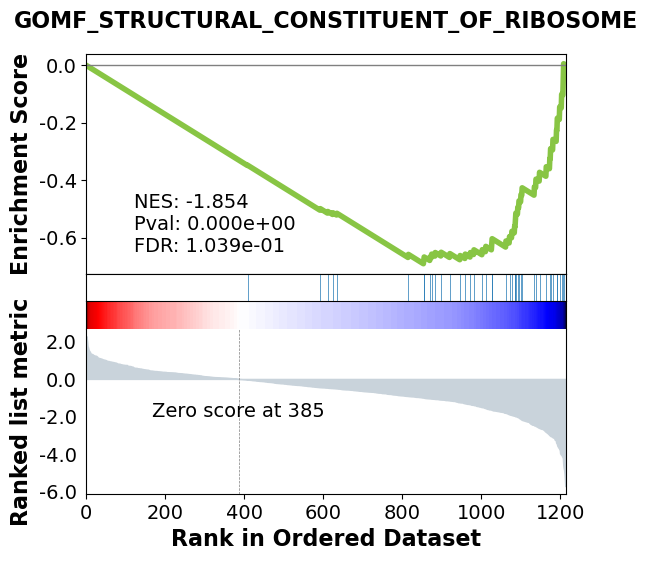

In [146]:
from gseapy import gseaplot
terms = pre_res.res2d.Term
i = 1
# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking,
         term=terms[3],
         **pre_res.results[terms[3]])

In [147]:
top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='50%')

top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='75%')
top_s = filter_by_quartile(dfreg, 'log_s_het', quartile='75%')
top_top_ = top_expressed.index.intersection(top_s.index)
top_nmd_ = filter_by_quartile(dfreg.loc[top_top_], 'NMD', quartile='25%', top=False)

gene_list = list(top_nmd_.gene_name)

In [148]:
enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

2023-06-14 00:29:53,278 [INFO] User defined gene sets is given: ../../c5.all.v2023.1.Hs.symbols.gmt
2023-06-14 00:29:53,543 [INFO] Run: c5.all.v2023.1.Hs.symbols.gmt 
2023-06-14 00:30:02,122 [INFO] Background is not set! Use all 19384 genes in c5.all.v2023.1.Hs.symbols.gmt.
2023-06-14 00:30:15,102 [INFO] Done.


<Axes: title={'center': 'Important genes NMD Q1\nMSigDB C5 Ontology'}, xlabel='Odds Ratio'>

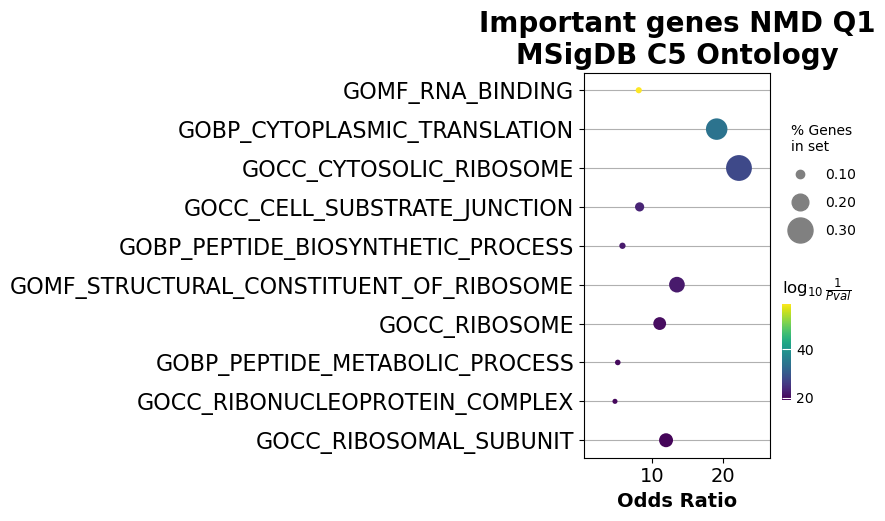

In [149]:
dotplot(enr2.res2d, title='Important genes NMD Q1\nMSigDB C5 Ontology',cmap='viridis', size=10, figsize=(3,5))

<Axes: title={'center': 'title'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

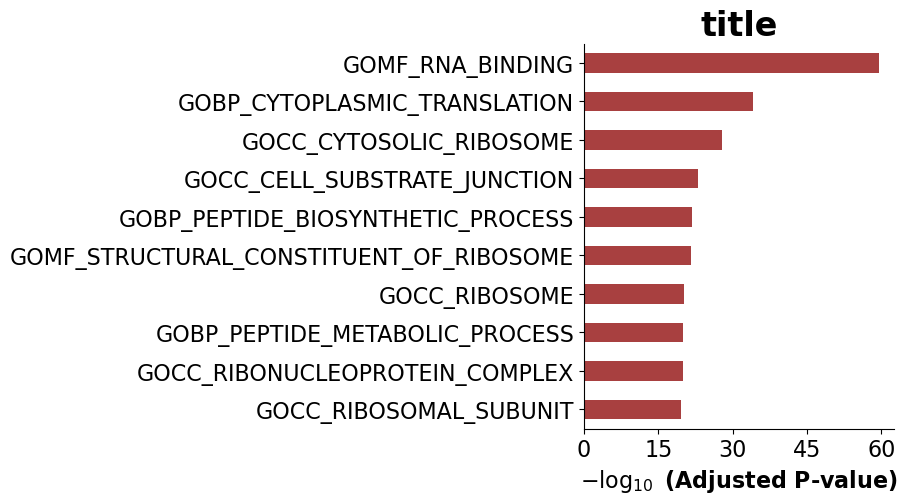

In [150]:
barplot(enr2.res2d,title='title', figsize=(4, 5), color='darkred')


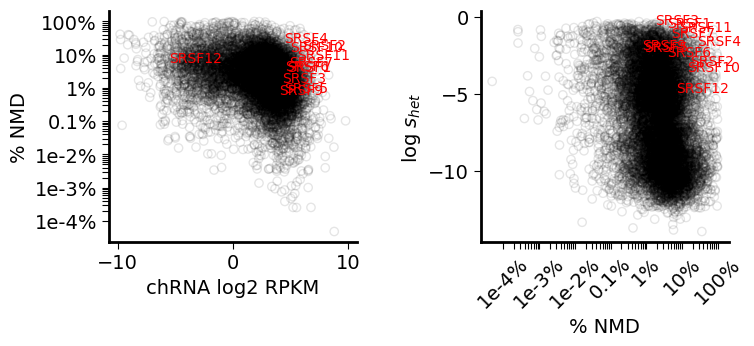

In [188]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(dfreg.RPKM, dfreg.NMD, **kwargs)
for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
    ax[0].annotate(row.gene_name, (row.RPKM-1, row.NMD-0.2), c='red', size=10)
    
ax[1].scatter(dfreg.NMD, dfreg.log_s_het, **kwargs)
for idx, row in dfreg.loc[srsf_ensembl.intersection(dfreg.index)].iterrows():
    ax[1].annotate(row.gene_name, (row.NMD, row.log_s_het), c='red', size=10)



for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('% NMD', size=14)

ax[1].set_xlabel('% NMD', size=14)
ax[1].set_ylabel('log $s_{het}$', size=14)

y_locs = [np.log2(x) for x in [1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]]
y_str = ['1e-4%', '1e-3%', '1e-2%', '0.1%', '1%', '10%', '100%']

# y_locs = list(np.linspace(0.00001, 0.00009, 9))
# y_locs += list(np.linspace(0.0001, 0.0009, 9))

# y_locs += list(np.linspace(0.001, 0.009, 9))

# y_locs += list(np.linspace(0.01, 0.09, 9))

y_locs = list(np.linspace(0.1, 1, 10))
y_locs += list(np.linspace(0.01, 0.09, 9))
y_locs += list(np.linspace(0.001, 0.009, 9))
y_locs += list(np.linspace(0.0001, 0.0009, 9))
y_locs += list(np.linspace(0.00001, 0.00009, 9))
y_locs += list(np.linspace(0.000001, 0.000009, 9))

y_locs = [np.log2(x) for x in y_locs]

y_str = ['10%'] + [""]*8 + ['100%']
y_str += ['1%'] + [""]*8 
y_str += ['0.1%'] + [""]*8 
y_str += ['1e-2%'] + [""]*8 
y_str += ['1e-3%'] + [""]*8 
y_str += ['1e-4%'] + [""]*8 

# y_str = ['1e-3'] + ['']*9 + ['1e-2'] + ['']*9 + ['1e-1'] + ['']*9 + ['1']

# y_locs = [np.log2(x) for x in [1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]]
# y_str = ['1e-4%', '1e-3%', '1e-2%', '0.1%', '1%', '10%', '100%']

ax[0].set_yticks(y_locs, y_str)
ax[1].set_xticks(y_locs, y_str, rotation=45)

# ticks = ax[0].get_yticks()
# ticklabels = ax_.get_yticklabels()

# # Make the first, tenth, twentieth, and thirtieth ticks twice as long
# for i, tick in enumerate(ticks):
#     if i in (0, 9, 17, 26, 35):
#         ax[0].axhline(y=tick, color='black', linewidth=2)
#     else:
#         ax[0].axhline(y=tick, color='black', linewidth=1)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.show()

# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)